In [19]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))
 
# %matplotlib inline

import os
import sys
import platform
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from flopy.export.shapefile_utils import shp2recarray
from rasterio import Affine
from flopy.utils.reference import SpatialReference
from flopy.utils.postprocessing import get_transmissivities, get_water_table, get_gradients

import shapefile    # not used directly here but for some reason flopy needs this to do shapefile stuff and BTW its not import pyshp as you would think its import shapefile, dumb...
import pandas as pd
import fiona
from rasterio.features import rasterize
import rasterio
import rasterio.mask
import geopandas
from osgeo import gdal

#import simplekml
import ogr
from shapely.wkb import loads

from scipy.interpolate import interp2d
import scipy.optimize as opt


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name = 'mf2005.exe'

workspace = os.path.join("..", "..", 'RISA_yr6_GIT_ignored_files', 'Flo_py_wrkspace_3')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)
    
figurespace = os.path.join(workspace, "Figures")
if not os.path.exists(figurespace):
    os.makedirs(figurespace)
    
WGS84UTM2S_string = 'PROJCS["WGS_1984_UTM_Zone_2S",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]'
pd.set_option('display.max_rows', 75)

# define the spatial reference object 
model_epsg = 32702   # epsg code specifying coordinate reference system: in this case, UTM zone 2S, WGS 84, A proj4 string has also been fetched from <spatialreference.org> using the supplied epsg code.

# in line plotting and saving options. Change these to plot or not to plot inline
Plotnsave_plot = True
Plotnsave_save = True

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 16:38:51) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.18.1
matplotlib version: 3.1.3
flopy version: 3.3.0


# Model geometry notes


model boundaries square at 
X	Y
- 530200	8425825
- 537700	8425825
- 537700	8418325
- 530200	8418325

with length of 7500 m on both sides


next steps 
- try and just follow existing github model notebook 

Shapefile Boundaries: (530200.0, 8418325.0, 537700.0000000009, 8425825.000000002)
wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace_3\Model_polyarea.shp
wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace_3\Model_grid.shp


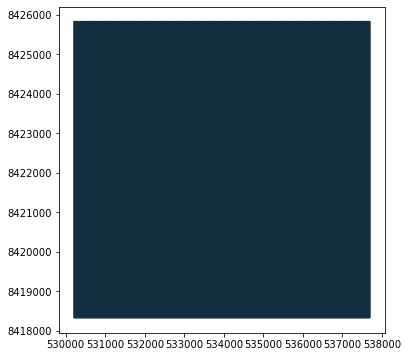

In [20]:
''' Define the number of layers, rows and columns.'''
# Note works at 100, 150, 300, 750
# Does not work at 600

ncol = 1500
nrow = 1500
nlay = 1

# model run times
nper = 1                     # Number of model stress periods (the default is 1)
perlen = [3650]              # An array of the stress period lengths in days separated by commas
nstp = [1]      # Number of time steps in each stress period (default is 1).
save_head = [3650]
steady = True
rotation = 0                             # rotation (positive counterclockwise)

# this cell inports the boundary shapefile to make the model around
ra = shp2recarray(os.path.join("..", "Data/Raw/GIS", 'model_square.shp'))
# these are the bondaries of the shapefile
shp_xmin = round(ra.geometry[0].bounds[0],1)
shp_ymin = round(ra.geometry[0].bounds[1],1)
shp_xmax = round(ra.geometry[0].bounds[2],1)
shp_ymax = round(ra.geometry[0].bounds[3],1)
print("Shapefile Boundaries: {}".format(ra.geometry[0].bounds))  

xll = int(shp_xmin)  # Lower left corner of model grid  
yll = int(shp_ymin)   # Lower left corner of model grid 


# grid spacing as a percentage of model x domain (in model units) note 10% buffer around boundary
delr = abs(int((shp_xmax-shp_xmin)/ncol))   # the width of each cell
delc = abs(int((shp_ymax-shp_ymin)/nrow))   # the height of eech cell
delr_4_sr  = np.ones(ncol, dtype=float) * delr    # This just puts the above into an array for the sr object 
delc_4_sr = np.ones(nrow, dtype=float) * delc   

# create the model boundary area polygon
sr = SpatialReference(delr=[delr_4_sr.sum()], delc=[delc_4_sr.sum()], xll=xll, yll=yll, rotation=rotation, proj4_str=WGS84UTM2S_string, lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_polyarea.shp'))          # write a shapefile of the model area for later use
prj = open(os.path.join(workspace, 'Model_polyarea.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()     # write the .prj file manually
#print("corners are at {}".format(sr.get_extent()))

# create the model boundary grid polygon   (NOTE THIS MUST OVERWRITE THe PREVIOUS sr. definition!)
sr = SpatialReference(delr=delr_4_sr, delc=delc_4_sr, xll=xll, yll=yll, rotation=rotation, proj4_str= '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs' , lenuni=2) #  # model length units (1 for feet, 2 for meters (default)) (also calculeted uper left corner of model) 
sr.write_shapefile(os.path.join(workspace, 'Model_grid.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Model_grid.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually

# output control parameters
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}    

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize=(12,6))
    Tutuila = geopandas.read_file(os.path.join("..", "Data/Raw/GIS", 'model_square.shp'))
    Grid = geopandas.read_file(os.path.join(workspace, 'Model_grid.shp'))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2)
    Tutuila.plot(ax=ax, linewidth=2, alpha = .3)

### Assign Layer elevations from a DEM

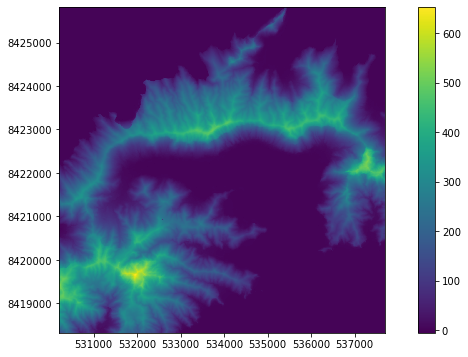

In [21]:
#Set model top to DEM
# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)
Raster_2_Clip = os.path.join("..",  'Data/Raw/GIS/3m_DEM', '3m_dem_cp.tif')
Clipped_raster = os.path.join(workspace, "DEM_10m_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
top = f(x2, y2)

botm = -500    # this will clearly need to change to accomadate the Tutuila bathymetry
top = np.where(top <= botm, botm+10, top) # force top elevations to always be higher than bottom elevations

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(top, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

Starting heads will be tricky.  Easiest might be to assign starting heads of 0.01 in ocean, then heads of 10 m less than top elevation in land surface areas, if optimization yields different starting heads then can modify. could also use the ending heads from the regional model. 


overall, I bound needs to be 

### starting heads

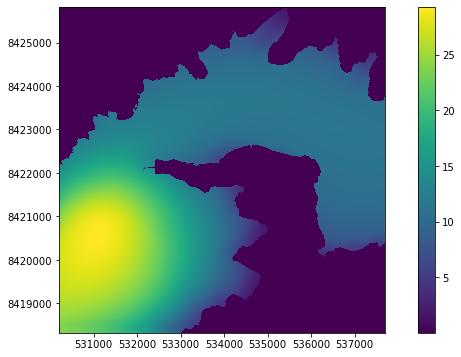

In [22]:
## First import regional heads from the regional model

Raster_2_Clip = os.path.join("..",  'Data/From_regional', 'PyPCGA_model_Heads_Clip.tif')
Clipped_raster = os.path.join(workspace, "PyPCGA_model_Heads_Clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features,
                                                        crop=True)
out_meta = src.meta.copy()

out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open(Clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
Top_raw = np.loadtxt(Clipped_raster, skiprows=7)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6

y = np.linspace(0, np.shape(Top_raw)[0]-1, np.shape(Top_raw)[0])   
x = np.linspace(0, np.shape(Top_raw)[1]-1, np.shape(Top_raw)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, Top_raw, kind='cubic')
regional_Heads = f(x2, y2)

#botm = -500    # this will clearly need to change to accomadate the Tutuila bathymetry
#top = np.where(top <= botm, botm+10, top) # force top elevations to always be higher than bottom elevations


# then explicitly say that the ocean area has a specified head, since the regional heads are fuzzy

with fiona.open(os.path.join("..",  'Data/Raw/GIS/ibounds/For_heads', 'Land_Ocean.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['OceanCell'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
mask = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

masked_heads = abs(regional_Heads)*mask                        # set ocean cells to a negative number through multoplication with -1
Ocean_starting_head = 0.01   # in meters 
start_heads = np.where(masked_heads < 0, Ocean_starting_head, masked_heads) # Set ocean cells (defined as any negative values in the array) to Ocean_starting_head value

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(start_heads, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### make new ibound and specified head 
- Negative ibound (-1) is constant head
- Ibound of (0) is inactive
- Any positive Ibound (1) is variable head (active) 

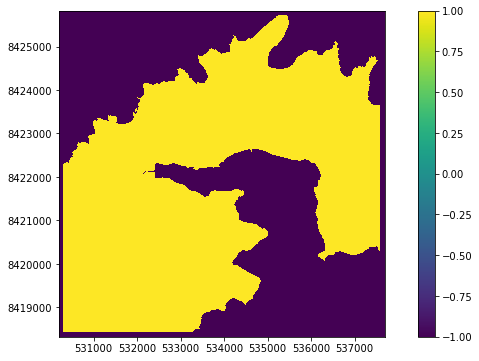

In [23]:
#### Use a Tutuila polygon to define the model active area as the island and the ghb cells as the offshore cells

with fiona.open(os.path.join("..", 'Data/Raw/GIS/ibounds', 'ibound_specHd_w_100m_buff.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['ibound'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
ibound = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(ibound, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### Create Drains 
this takes a minute

<ipython-input-24-bee9a9ac653a>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersections['RastVal'][intersections['RastVal'] > 3] = intersections['RastVal'] - 1
<ipython-input-24-bee9a9ac653a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersections['RastVal'][intersections['RastVal'] == 0] = 0.1  #(will make pink box)


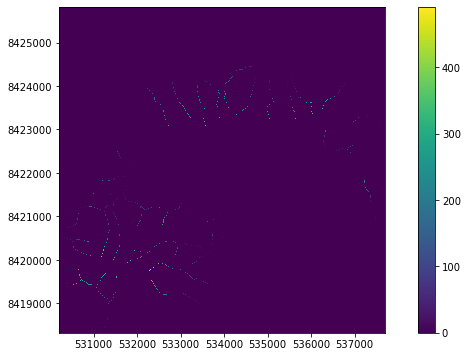

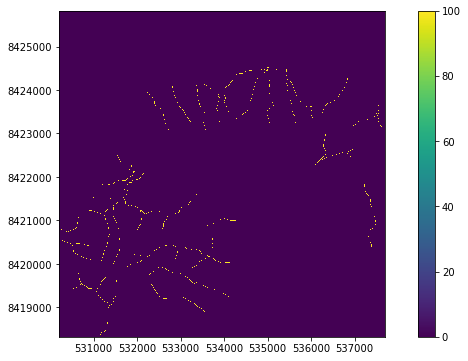

In [24]:
conductance_value = 3000

# Intersect streams with the grid cells using GEOPANDAS!! :)
lines = geopandas.GeoDataFrame.from_file(os.path.join("..", "Data/Raw/GIS", "Streams", 'Streams_Simplified_WGS2S.shp'))
poly = geopandas.GeoDataFrame.from_file(os.path.join(workspace, 'Model_grid.shp'))
# Do the spatial intersect to just pull out cells that hit streams
intersections= geopandas.sjoin(poly, lines, how="inner", op='intersects')
intersections["x"] = intersections.centroid.x # pull out the x coordiate
intersections["y"] = intersections.centroid.y # pull out the y coordiate
intersections["Cond"] = conductance_value
# Write the geopandas dataframe to a esri shapefile 
intersections.to_file(driver = 'ESRI Shapefile', filename = os.path.join(workspace, 'Stream_grid_intersects.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Stream_grid_intersects.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually

# Extract elevation values to the points from the DEM
Clipped_DEM_raster = os.path.join(workspace, "DEM_10m_clip.asc")   # from the DEM used above
src = rasterio.open(Clipped_DEM_raster) 
coords = [(x,y) for x, y in zip(intersections["x"], intersections["y"])]  # This woll pull the cooordinate values out of the centrods of the intersections frame above
intersections['RastVal'] = [x[0] for x in src.sample(coords)]

# Modify elevations a bit
intersections['RastVal'][intersections['RastVal'] > 3] = intersections['RastVal'] - 1

# Reset any values that ended up as 0s
intersections['RastVal'][intersections['RastVal'] == 0] = 0.1  #(will make pink box)

# Write to shapefile 
intersections.to_file(driver = 'ESRI Shapefile', filename = os.path.join(workspace, 'Stream_grid_intersects_Elevations.shp'))          # write a shapefile of the model grid for later use
prj = open(os.path.join(workspace, 'Stream_grid_intersects_Elevations.prj'), "w"); prj.write(WGS84UTM2S_string) ; prj.close()   # write the .prj file manually


# Create a model square array with the point values elevation as the elevation 
with fiona.open(os.path.join(workspace, 'Stream_grid_intersects_Elevations.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['RastVal'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
Stream_elev = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(Stream_elev, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

# Create a model square array with the point values conductance defined as whatever.
with fiona.open(os.path.join(workspace, 'Stream_grid_intersects_Elevations.shp')) as src:   #    read in Tutuila shapefile
    records = [r for r in src] 
geoms = [r['geometry'] for r in records]       # shapefile shape
attr = [r['properties'] for r in records]      # shapefile attributes
geoms = [(g, attr[i]['Cond'])for i, g in enumerate(geoms) ]              # select the attribute to map onto the raster grid
# affine: work with the geometry to change from raster to grid reference frame 
trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
Stream_conductance = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(Stream_conductance, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)


# Save in Flopy friendly format
drnElv_lst = pd.DataFrame({
                 'lay':  0,
                 'row':  np.nonzero(Stream_elev)[0], # + 1,
                 'col':  np.nonzero(Stream_elev)[1], # + 1,
                 'elv':  Stream_elev[np.nonzero(Stream_elev)],
                 'cond': Stream_conductance[np.nonzero(Stream_conductance)]}, 
             columns=['lay', 'row', 'col', 'elv', 'cond'])

# Convert the DataFrame into a list of lists for the drn constructor
stress_period_data = drnElv_lst.values.tolist()

# Create a dictionary, 1 entry for each of the stress periods.
stress_period_data_drain = {0: stress_period_data}    

### Pumping wells 
Using ASPA data and the average pumprates 2005-2017 based on ly last wells pumprate master sheet 

In [25]:
Pump_wells = pd.read_csv(os.path.join("..",  'Data/Raw/GIS/Pump_wells', 'ASPA_wells_clip_UTM2s.csv'))

Pump_wells['col_num'] = Pump_wells['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate   Not sure why rows and cols are opposite what you think but they are
Pump_wells['row_num'] = Pump_wells['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pump_wells['rowcol']  = list(zip(Pump_wells.row_num, Pump_wells.col_num)) 

# This takes obs wells that occupy the same cell and averages them! 
Unique_PumpWells = Pump_wells.groupby('rowcol', as_index=False).sum()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_PumpWells["name"] = "PumpWellCell_"+Unique_PumpWells.index.map(str)

# set layer values 
Unique_PumpWells["Layer"] = 0

# Convert GPM to m3/d
Unique_PumpWells["m3pd"] = Unique_PumpWells["PumpGMP"]*-5.45099

SP_frame = Unique_PumpWells[['Layer', 'row_num', 'col_num', 'm3pd']]

stress_period_data = SP_frame.values.tolist()
# Create a dictionary, 1 entry for each of the stress periods.
stress_period_data_PmpWells = {0: stress_period_data}

### Observation points

note need to cut out obs that are not within the model domain

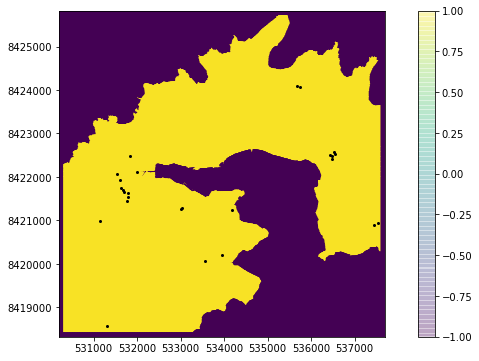

In [26]:
Pdevel_WLs = pd.read_csv(os.path.join("..",  'Data/Raw/Water_levels', 'Predevelop_WLs_MOD_vai183.csv'))

# Cut out observations that are outside of the model square (dont need the y's but could add those too for shoots and giggls
Pdevel_WLs = Pdevel_WLs[Pdevel_WLs['x_utm'] > shp_xmin]
Pdevel_WLs = Pdevel_WLs[Pdevel_WLs['x_utm'] < shp_xmax]

Pdevel_WLs['col_num'] = Pdevel_WLs['x_utm'].apply(lambda x_utm_val: math.ceil((x_utm_val-xll)/delr) )          # this formula calculates the column number based on the x coordinate   Not sure why rows and cols are opposite what you think but they are
Pdevel_WLs['row_num'] = Pdevel_WLs['y_utm'].apply(lambda y_utm_val: (1+nrow)-math.ceil((y_utm_val-yll)/delc) )   # this formula calculates the row number based on the y coordinate 
Pdevel_WLs['rowcol']  = list(zip(Pdevel_WLs.row_num, Pdevel_WLs.col_num))                                      # just make a tuplel of the row and col

# This takes obs wells that occupy the same cell and averages them! 
Unique_WLs = Pdevel_WLs.groupby('rowcol', as_index=False).mean()                                               # Average the duplicate WLs that fall into a single cell, to get one "observed" water level for that cell 

# make new unique names for each obs point
Unique_WLs["name"] = "Obs_"+Unique_WLs.index.map(str)

nobs = len(Unique_WLs['WL_m_MSL']) 
layervals = [0] * nobs
rowvals = list(Unique_WLs['row_num'].astype(int))
colvals = list(Unique_WLs['col_num'].astype(int))
obsvals = list(Unique_WLs['WL_m_MSL'])
obsnames = list(Unique_WLs["name"])

if Plotnsave_plot: 
    gdf = geopandas.GeoDataFrame(Unique_WLs, geometry=geopandas.points_from_xy(Unique_WLs.x_utm, Unique_WLs.y_utm))
    fig, ax = plt.subplots(figsize = (12,6))
    Grid.plot(ax=ax, facecolor="white", edgecolor="Black", linewidth=.2, alpha = .2)
    qm = sr.plot_array(ibound, ax=ax, alpha = .2)
    ax.set_aspect(1); plt.colorbar(qm)
    gdf.plot(ax=ax, color='black', markersize=4)

### Import Recharge .asc from SWB output into MODFLOW rech array
(note I am not sure what happens when the model area is bigger then the raster....)

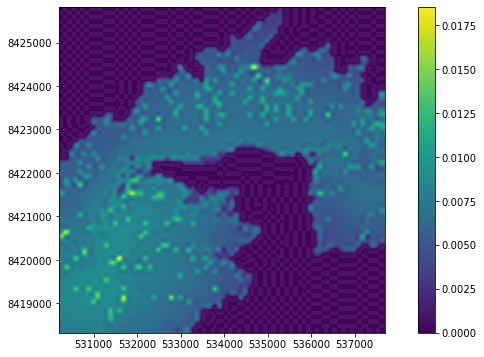

In [27]:
SWB_output_recharge = os.path.join("..",  'Data/Raw/GIS/Recharge','recharge_v1.asc')  

# Needed to clip the raster to appropriate dimensions, () https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html)   
Raster_2_Clip = os.path.join(SWB_output_recharge)
Clipped_raster = os.path.join(workspace, "raw_net_infiltration_clip.asc")

with fiona.open(os.path.join(workspace, 'Model_polyarea.shp'), "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(Raster_2_Clip) as src:
    out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
    
out_meta = src.meta.copy()
out_meta.update({"driver": "AAIGrid",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(Clipped_raster, "w", **out_meta) as dest:          # create the new clipped .asc file
    dest.write(out_image)
    
# Now disect the clipped .asc into a 
recharge_raw_SWB = np.loadtxt(Clipped_raster, skiprows=6)

y = np.linspace(0, np.shape(recharge_raw_SWB)[0]-1, np.shape(recharge_raw_SWB)[0])   
x = np.linspace(0, np.shape(recharge_raw_SWB)[1]-1, np.shape(recharge_raw_SWB)[1])

y2 = np.linspace(0, np.shape(y)[0], nrow)   # this defines the number of cells to resample to on the y direction, first number is the original height of the SWB2 recharge map, second number is going to be new height in # of cells
x2 = np.linspace(0, np.shape(x)[0], ncol)   # this defines the number of cells to resample to on the x direction, first number is the original width of the SWB2 recharge map, second number is going to be new width in # of cells

f = interp2d(x, y, recharge_raw_SWB, kind='cubic')
recharge_resampled = f(x2, y2)
recharge_converted =  recharge_resampled* (0.0254/365)   # recharge comes out of SWB in inches/year and needs to be converted to m/day

recharge_converted = np.where(recharge_converted < 0, 0.001, recharge_converted)   # Interpolation made some negative values, fix that issue by setting them to a positive value

rch_data = {0: recharge_converted}   # dictionary form to specify that it is only on first layer

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(recharge_converted, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

### Hydraulic condictivty assigned based on zones as defined by shapefiles in a folder

The values at the top of this cell can be modified to change the conductivity in each zone

In [28]:
# Function to rasterize the HK zones: 
def rastah_zone(shp):
    with fiona.open(shp) as src:   #    read in Tutuila shapefile
            records = [r for r in src]   
    geoms = [r['geometry'] for r in records]       # shapefile shape
    attr = [r['properties'] for r in records]      # shapefile attributes
    geoms = [(g, attr[i]['par_code']) for i, g in enumerate(geoms)]              # select the attribute to map onto the raster grid
    # affine: work with the geometry to change from raster to grid reference frame 
    trans = Affine(delr, rotation, sr.xul, sr.rotation, -delc, sr.yul)
    Outrastah = rasterize(geoms, out_shape=(nrow, ncol), transform=trans) # the actual rasterization 
    return Outrastah

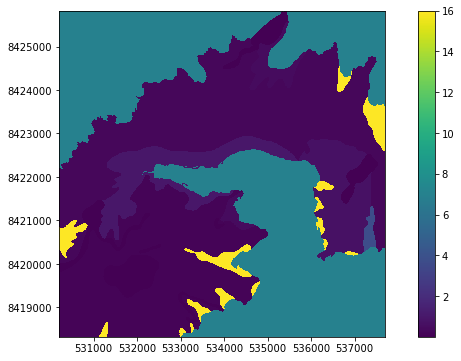

In [29]:
# set the  values this cell is set up for optimization
HK_raster = rastah_zone(os.path.join("..",  'Data/Raw/GIS/Geo_units/v2', 'NPS_simplified_geo_v2.shp'))

## Initial starting point before 3-4 rounds of calibration  was calgood = [ 5, 5, 5, 5, 5, 5, 0.2, .2, .2, .4, 0.5, 5]
#calgood =  [2.6, 39, 1, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.3, 1]

calgood = [0.7, 16, 16,  0.5, 1.0, 0.5, 0.002, 0.75, 0.17, 0.3, 0.0018, 3.75] 


Alluvium_Aua      = calgood[0]
Alluvium_Fagaalu  = calgood[1]
Alluvium_minor    = calgood[2]
Alluvium_Utulei   = calgood[3]
Alluvium_Vaipito  = calgood[4]
Alluvium_Vatia    = calgood[5]
Dikes             = calgood[6]
Pago_inner_E      = calgood[7]
Pago_inner_W      = calgood[8]
Pago_outer        = calgood[9]
Trachyte          = calgood[10]
Alluvium_Laulii   = calgood[11]


map_dic = {-12:Alluvium_Aua, 
           -14:Alluvium_Fagaalu, 
           -15:Alluvium_minor,
           -13:Alluvium_Utulei,
           -11:Alluvium_Vaipito,
           -10:Alluvium_Vatia,
           -50:Dikes,
           -30:Pago_inner_E,
           -40:Pago_inner_W,
           -20:Pago_outer,
           -60:Trachyte, 
           -16:Alluvium_Laulii}

for i in map_dic:
    HK_raster = np.where(HK_raster== i, map_dic[i], HK_raster)
    
HK_raster = np.where(HK_raster== 0, 7, HK_raster)   # this is for the areas not covered by HK zones, the number Should not actually maatter at all!

#HK_raster = np.where(HK_raster== -90, 1, HK_raster) # this is for the areas that get messed up somehow
#HK_raster = np.where(HK_raster== -70, 1, HK_raster) # this is for the areas that get messed up somehow

if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(HK_raster, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

'''Define the layers to be confined and define the horizontal and vertical 
hydraulic conductivity of the aquifer for the LPF package.'''

# lpf data
laytyp = 0
vka = 10


In [30]:
modelname = 'modelface'

ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)

discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                   delr=delr, delc=delc, top=top, botm=botm,
                                   nper=nper, perlen=perlen, nstp=nstp)
bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=start_heads)
lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)
#### ghb = flopy.modflow.ModflowGhb(ml, stress_period_data=ghb_data)
rch = flopy.modflow.ModflowRch(ml, rech=rch_data)
oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)
drn = flopy.modflow.ModflowDrn(ml, ipakcb=53, print_flows=True, stress_period_data=stress_period_data_drain)  # ipakcb=53, is flag for writing SFR output to cell-by-cell budget (on unit 53)
wel = flopy.modflow.ModflowWel(model = ml, stress_period_data=stress_period_data_PmpWells)

# water level observations
obs_data= []
for i in range(0,nobs):
    obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
    obs_data.append(obs)
hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)

# Run model 

if needed: #### Model checker
https://notebook.community/brclark-usgs/flopy/examples/Notebooks/flopy3_ModelCheckerExample
- ml.check()

In [31]:
ml.write_input()
ml.run_model(silent=False)

FloPy is using the following  executable to run the model: .\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: modelface.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/10/10  6:33:32

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/10/10  6:34:33
 Elapsed run time:  1 Minutes,  0.509 Seconds

  Normal termination of simulation


(True, [])

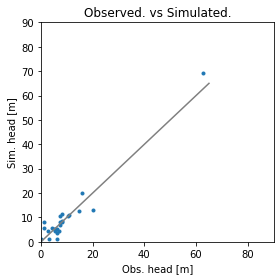

Mean Error: 0.41
Mean Absolute Error: 2.26
RMS Error: 3.13


In [32]:
# plot observations 
observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

# note positive residuals means model is calculating too high negative is model calculates too low 
residuals = []
for idx, i in enumerate(observations):   
    r = observations[idx][0]-observations[idx][1]
    residuals.append(r)

Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})

fig = plt.figure(figsize=(4,4))
plt.title('Observed. vs Simulated.')
plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
#plt.axis('equal')
#plt.axis('square')
plt.xlabel("Obs. head [m]")
plt.ylabel('Sim. head [m]')
plt.ylim(0,90)
plt.xlim(0,90)

plt.plot([0,20,65],[0,20,65], color= "grey")
plt.tight_layout()
plt.savefig(os.path.join(figurespace, "calibration_result.pdf"))

plt.show()

me = np.mean(Howd_we_do.Residual_m)
mea = np.mean(np.abs(Howd_we_do.Residual_m))
rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
print ('Mean Error: {:.2f}\nMean Absolute Error: {:.2f}\nRMS Error: {:.2f}'.format(me, mea, rmse))

## Post process, map and extract results to heads raster file

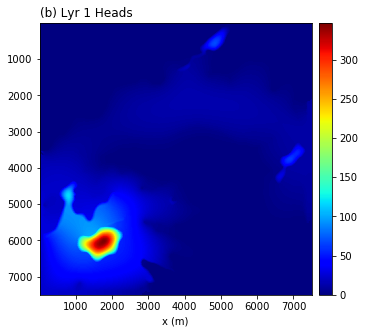

wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace_3\heads.asc


In [35]:
# develop geometry to plot heads as colormap
N = np.array([ncol, nrow, nlay])
dx = np.array([delc, delr, abs(botm)])
Lx = delc*ncol
Ly = delr*nrow
x = np.linspace(0. + dx[0] / 2., Lx - dx[0] / 2., N[0])
y = np.linspace(0. + dx[1] / 2., Ly - dx[1] / 2., N[1])
XX, YY = np.meshgrid(x, y)

# Extract heads data
hds = bf.HeadFile(os.path.join(workspace, '{}.hds'.format(modelname)))
times = hds.get_times() # simulation time, steady state
head = hds.get_data(totim=times[-1])
minv = 0
maxv = head.max()

# Plot em
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
im1 = axes.pcolormesh(XX, YY, head[0], vmin=minv, vmax=maxv, cmap=plt.get_cmap('jet'))
axes.set_title('(b) Lyr 1 Heads', loc='left')
axes.set_xlabel('x (m)')
axes.set_aspect('equal')
axes.axis([XX.min(), XX.max(), YY.max(), YY.min()])
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes)
cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im1, cax=cbar_ax)
plt.show()

# Write the heads layer(s) to a raster file
# export head rasters 
output_raster = os.path.join(workspace, 'heads.asc')   # if there are multiple layers exports based on each layer
grid = ml.modelgrid
flopy.export.utils.export_array(grid, output_raster, head[0])

# Project the output .asc into WGS84 space with manual  ASC header modification 
new_first = ('ncols {}\n'                        # these are the parameters for the .asc file
             'nrows {}\n'
             'xllcorner {}\n'
             'yllcorner {}\n'
             'cellsize {}\n'
             'NODATA_value -999.0'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))

with open(os.path.join('.', output_raster), 'r') as fin:   # open file 
    data = fin.read().splitlines(True)
with open(os.path.join('.', output_raster), 'w') as fout:     # delete first line
    fout.writelines(data[6:])
    
with open(os.path.join('.', output_raster), 'r+') as file:                # add in new first line and save file  
    file_data = file.read()
    file. seek(0, 0)
    file. write(new_first + '\n' + file_data)

### Calculate Depth to water


wrote ..\..\RISA_yr6_GIT_ignored_files\Flo_py_wrkspace_3\dep2Wat.asc


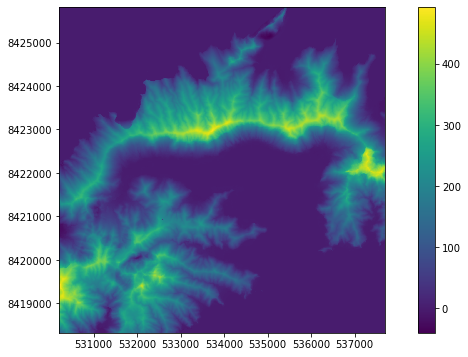

In [36]:
# Super basic depth to water calculation, Currently allows for negative depths (i.e. flooding)
Heads_raw = np.loadtxt(os.path.join(workspace, 'heads.asc'), skiprows=6)   # the 7th row was a no data row for some reason not sure why, if another DEM is used might need to skiprows back to 6
Dep_to_wat = top-Heads_raw

# Write the GIS asc raster from the NP array 
output_raster = os.path.join(workspace, 'dep2Wat.asc')   # if there are multiple layers exports based on each layer
grid = ml.modelgrid
flopy.export.utils.export_array(grid, output_raster, Dep_to_wat)

# Project the output .asc into WGS84 space with manual  ASC header modification 
new_first = ('ncols {}\n'                        # these are the parameters for the .asc file
             'nrows {}\n'
             'xllcorner {}\n'
             'yllcorner {}\n'
             'cellsize {}\n'
             'NODATA_value -999.0'.format(ncol,nrow, xll, yll, np.mean([delc, delr]) ))

with open(os.path.join('.', output_raster), 'r') as fin:   # open file 
    data = fin.read().splitlines(True)
with open(os.path.join('.', output_raster), 'w') as fout:     # delete first line
    fout.writelines(data[6:])
    
with open(os.path.join('.', output_raster), 'r+') as file:                # add in new first line and save file  
    file_data = file.read()
    file. seek(0, 0)
    file. write(new_first + '\n' + file_data)
    
    
if Plotnsave_plot: 
    fig, ax = plt.subplots(figsize = (12,6))
    qm = sr.plot_array(Dep_to_wat, ax=ax)
    ax.set_aspect(1); plt.colorbar(qm)

## Run a basic zonal optimzation calibration

In [37]:
def plot_calibrateo(Howd_we_do):
    
    #Plot the OBS plot if want
    fig = plt.figure(figsize=(4,4))
    plt.title('Observed. vs Simulated.')
    plt.plot(Howd_we_do["Obs_hed_m"], Howd_we_do["Comp_hed_m"], '.')
    #plt.axis('equal')
    #plt.axis('square')
    plt.xlabel("Obs. head [m]")
    plt.ylabel('Sim. head [m]')
    plt.ylim(0,90)
    plt.xlim(0,90)
    plt.plot([0,30,65],[0,30,65], color= "grey")
    plt.tight_layout()
    plt.savefig("cal.pdf")
    plt.show()


def calibrateo(params):
    
    Alluvium_Aua, Alluvium_Fagaalu, Alluvium_minor, Alluvium_Utulei, Alluvium_Vaipito, Alluvium_Vatia, Dikes, Pago_inner_E, Pago_inner_W, Pago_outer, Trachyte, Alluvium_Laulii= params   
    
    # set the  values this cell is set up for optimization
    HK_raster = rastah_zone(os.path.join("..",  'Data/Raw/GIS/Geo_units/v2', 'NPS_simplified_geo_v2.shp'))

    map_dic = {-12:Alluvium_Aua, 
               -14:Alluvium_Fagaalu, 
               -15:Alluvium_minor,
               -13:Alluvium_Utulei,
               -11:Alluvium_Vaipito,
               -10:Alluvium_Vatia,
               -50:Dikes,
               -30:Pago_inner_E,
               -40:Pago_inner_W,
               -20:Pago_outer,
               -60:Trachyte,    
               -16:Alluvium_Laulii}

    for i in map_dic:
        HK_raster = np.where(HK_raster== i, map_dic[i], HK_raster)

    HK_raster = np.where(HK_raster== 0, 7, HK_raster)   # this is for the areas not covered by HK zones, Should not actually maatter at all!
    
    
    
    ############    Now generate the run the new model         
    modelname = 'model_pago_OPT'  
        
    ml = flopy.modflow.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace, verbose=False)
    
    discret = flopy.modflow.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=0,
                                       delr=delr, delc=delc, top=top, botm=botm,
                                       nper=nper, perlen=perlen, nstp=nstp)
    
    bas = flopy.modflow.ModflowBas(ml, ibound=ibound, strt=start_heads)
    lpf = flopy.modflow.ModflowLpf(ml, laytyp=laytyp, hk=HK_raster, vka=vka)
    rch = flopy.modflow.ModflowRch(ml, rech=rch_data)
    oc = flopy.modflow.ModflowOc(ml, stress_period_data=spd)
    pcg = flopy.modflow.ModflowPcg(ml, hclose=1.0e-6, rclose=3.0e-3, mxiter=100, iter1=50)
    drn = flopy.modflow.ModflowDrn(ml, ipakcb=53, print_flows=True, stress_period_data=stress_period_data_drain)  # ipakcb=53, is flag for writing SFR output to cell-by-cell budget (on unit 53)
    wel = flopy.modflow.ModflowWel(model = ml, stress_period_data=stress_period_data_PmpWells)


    # water level observations
    obs_data= []
    for i in range(0,nobs):
        obs = flopy.modflow.HeadObservation(ml, obsname=obsnames[i], layer=layervals[i], row=rowvals[i], column=colvals[i], time_series_data=[[0,obsvals[i]]])
        obs_data.append(obs)
    hob = flopy.modflow.ModflowHob(ml, iuhobsv = 7, hobdry=-999, obs_data = obs_data)        
    
    
    # Run da model 
    ml.write_input()
    ml.run_model(silent=True)


    # post process observations 
    observations = np.loadtxt(os.path.join(workspace, '{}.hob.out'.format(modelname)), skiprows=1, usecols=[0,1])      # this block extracts observation data at each well field and determines what the maximum residual at any of the given points is
    comp_obs = np.ravel(np.split(observations, 2, 1)[0]) # the computed hed values at the obspts
    obs_obs = np.ravel(np.split(observations, 2, 1)[1]) # the observed hed values at the obspts

    # note positive residuals means model is calculating too high negative is model calculates too low 
    residuals = []
    for idx, i in enumerate(observations):   
        r = observations[idx][0]-observations[idx][1]
        residuals.append(r)

    Howd_we_do = pd.DataFrame({"Obs_hed_m":obs_obs,"Comp_hed_m":comp_obs,"Residual_m":residuals})
    # error metrics
    me = np.mean(Howd_we_do.Residual_m)
    mea = np.mean(np.abs(Howd_we_do.Residual_m))
    rmse = np.sqrt(np.mean(Howd_we_do.Residual_m**2))
    
    
    # Plot if want
    plot_calibrateo(Howd_we_do)

    print("Error is - {}".format(rmse))
    print("Params are - {}".format(params))
    return rmse






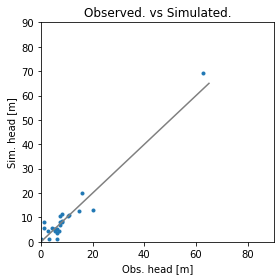

Error is - 3.133658207882991
Params are - [0.7, 16, 16, 0.5, 1.0, 0.5, 0.002, 0.75, 0.17, 0.3, 0.0018, 3.75]


3.133658207882991

In [38]:
# Run once 
# params = [4.6, 13.0, 0.1, 5.0, 2.6, 0.4, 0.3, 0.1, 0.5, 0.6, 0.3]
params = [2.6, 39, 1, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.3, 1]
params = [0.7, 32, 6.8, 1.9, 1.5, 5.0, 0.001, 1.0, 0.25, 0.2, 0.0015, 2.5] 

#[0.7, 32, 6.8, 1.9, 1.5, 5.0, 0.001, 1.0, 0.25, 0.2, 0.0015, 2.5] 

params = [0.7, 16, 16,  0.5, 1.0, 0.5, 0.002, 0.75, 0.17, 0.3, 0.0018, 3.75] 

calibrateo(params)

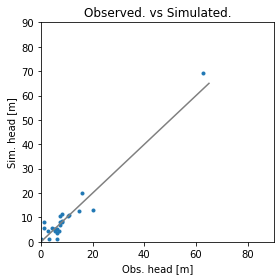

Error is - 3.133658207882991
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.00e-03 7.50e-01
 1.70e-01 3.00e-01 1.80e-03 3.75e+00]


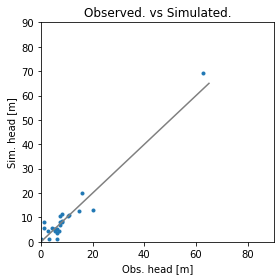

Error is - 3.1332162865701374
Params are - [7.35e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.00e-03 7.50e-01
 1.70e-01 3.00e-01 1.80e-03 3.75e+00]


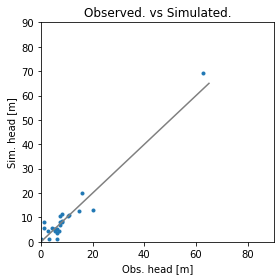

Error is - 3.134119430536306
Params are - [7.00e-01 1.68e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.00e-03 7.50e-01
 1.70e-01 3.00e-01 1.80e-03 3.75e+00]


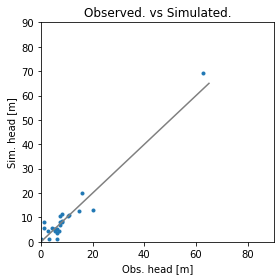

Error is - 3.1345010709382164
Params are - [7.00e-01 1.60e+01 1.68e+01 5.00e-01 1.00e+00 5.00e-01 2.00e-03 7.50e-01
 1.70e-01 3.00e-01 1.80e-03 3.75e+00]


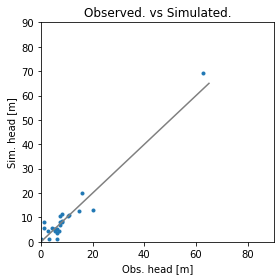

Error is - 3.1334560735306205
Params are - [7.00e-01 1.60e+01 1.60e+01 5.25e-01 1.00e+00 5.00e-01 2.00e-03 7.50e-01
 1.70e-01 3.00e-01 1.80e-03 3.75e+00]


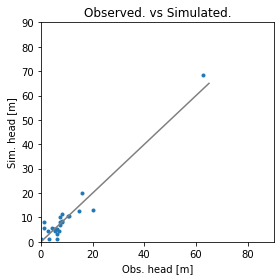

Error is - 3.0902154650449423
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.05e+00 5.00e-01 2.00e-03 7.50e-01
 1.70e-01 3.00e-01 1.80e-03 3.75e+00]


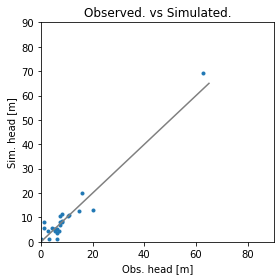

Error is - 3.133384801554859
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.25e-01 2.00e-03 7.50e-01
 1.70e-01 3.00e-01 1.80e-03 3.75e+00]


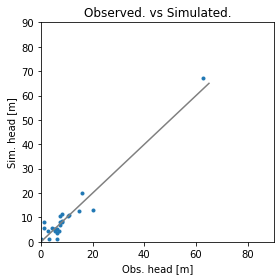

Error is - 2.998463668519367
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.10e-03 7.50e-01
 1.70e-01 3.00e-01 1.80e-03 3.75e+00]


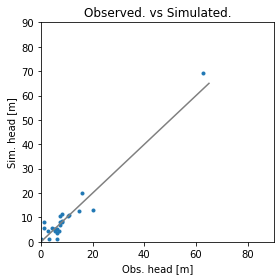

Error is - 3.1341949770753352
Params are - [7.000e-01 1.600e+01 1.600e+01 5.000e-01 1.000e+00 5.000e-01 2.000e-03
 7.875e-01 1.700e-01 3.000e-01 1.800e-03 3.750e+00]


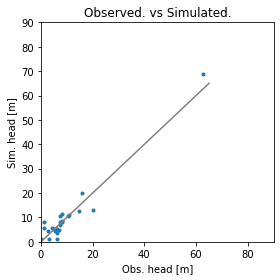

Error is - 3.110642137814693
Params are - [7.000e-01 1.600e+01 1.600e+01 5.000e-01 1.000e+00 5.000e-01 2.000e-03
 7.500e-01 1.785e-01 3.000e-01 1.800e-03 3.750e+00]


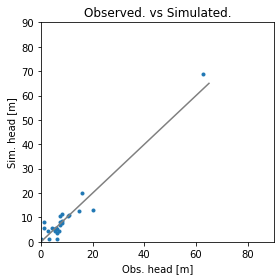

Error is - 3.125577234058746
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.00e-03 7.50e-01
 1.70e-01 3.15e-01 1.80e-03 3.75e+00]


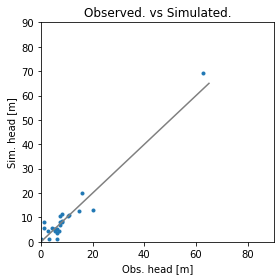

Error is - 3.133536080505058
Params are - [7.00e-01 1.60e+01 1.60e+01 5.00e-01 1.00e+00 5.00e-01 2.00e-03 7.50e-01
 1.70e-01 3.00e-01 1.89e-03 3.75e+00]


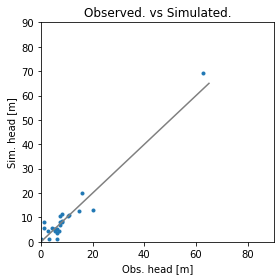

Error is - 3.13381881637483
Params are - [7.0000e-01 1.6000e+01 1.6000e+01 5.0000e-01 1.0000e+00 5.0000e-01
 2.0000e-03 7.5000e-01 1.7000e-01 3.0000e-01 1.8000e-03 3.9375e+00]


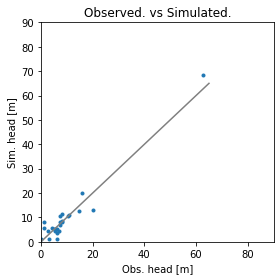

Error is - 3.09373066636914
Params are - [7.05833333e-01 1.61333333e+01 1.52000000e+01 5.04166667e-01
 1.00833333e+00 5.04166667e-01 2.01666667e-03 7.56250000e-01
 1.71416667e-01 3.02500000e-01 1.81500000e-03 3.78125000e+00]


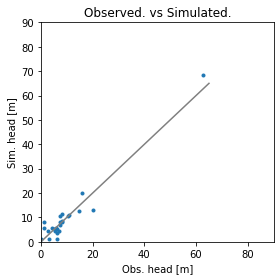

Error is - 3.0876700209404095
Params are - [7.06805556e-01 1.61555556e+01 1.58666667e+01 5.04861111e-01
 1.00972222e+00 5.04861111e-01 2.01944444e-03 7.13541667e-01
 1.71652778e-01 3.02916667e-01 1.81750000e-03 3.78645833e+00]


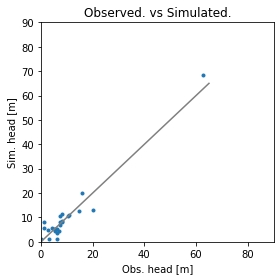

Error is - 3.080701427330293
Params are - [7.07939815e-01 1.52481481e+01 1.58444444e+01 5.05671296e-01
 1.01134259e+00 5.05671296e-01 2.02268519e-03 7.44965278e-01
 1.71928241e-01 3.03402778e-01 1.82041667e-03 3.79253472e+00]


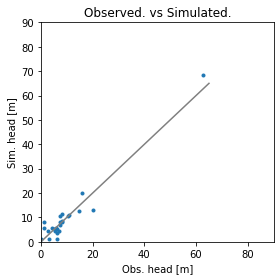

Error is - 3.072462161960711
Params are - [7.09263117e-01 1.59228395e+01 1.58185185e+01 5.06616512e-01
 1.01323302e+00 5.06616512e-01 2.02646605e-03 7.44126157e-01
 1.72249614e-01 3.03969907e-01 1.82381944e-03 3.58087384e+00]


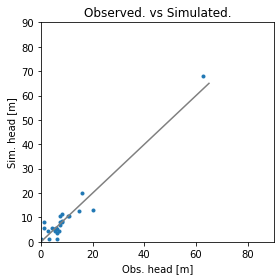

Error is - 3.063152232405475
Params are - [7.10806970e-01 1.59099794e+01 1.57882716e+01 5.07719264e-01
 1.01543853e+00 5.07719264e-01 2.03087706e-03 7.43147184e-01
 1.72624550e-01 3.04631559e-01 1.82778935e-03 3.74018615e+00]


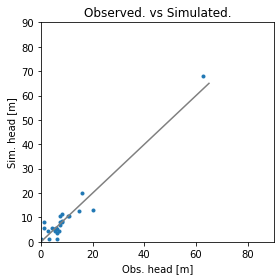

Error is - 3.052728780343119
Params are - [7.12608132e-01 1.58949760e+01 1.57529835e+01 5.09005808e-01
 1.01801162e+00 5.09005808e-01 2.03602323e-03 7.42005048e-01
 1.73061975e-01 3.05403485e-01 1.72742091e-03 3.73855051e+00]


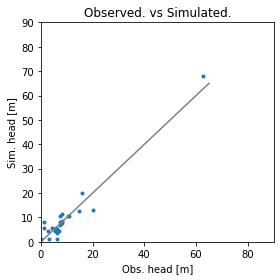

Error is - 3.040785437096863
Params are - [7.14709487e-01 1.58774720e+01 1.57118141e+01 4.81340110e-01
 1.02101355e+00 5.10506777e-01 2.04202711e-03 7.40672556e-01
 1.73572304e-01 3.06304066e-01 1.80532440e-03 3.73664226e+00]


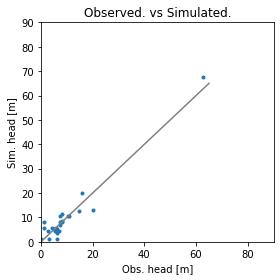

Error is - 3.0272939604349767
Params are - [7.17161068e-01 1.58570507e+01 1.56637832e+01 5.03230128e-01
 1.02451581e+00 4.83091239e-01 2.04903162e-03 7.39117981e-01
 1.74167688e-01 3.07354744e-01 1.80621179e-03 3.73441597e+00]


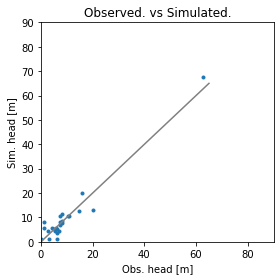

Error is - 3.012701896683067
Params are - [6.79187913e-01 1.58332258e+01 1.56077470e+01 5.03768483e-01
 1.02860178e+00 5.05273113e-01 2.05720356e-03 7.37304312e-01
 1.74862303e-01 3.08580534e-01 1.80724709e-03 3.73181863e+00]


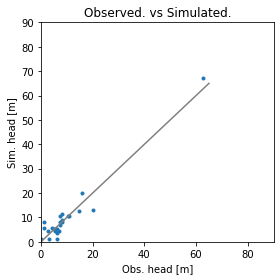

Error is - 3.0029233751808575
Params are - [7.10719232e-01 1.58054301e+01 1.55423715e+01 5.04396563e-01
 1.03336874e+00 5.06151965e-01 2.06673749e-03 7.35188364e-01
 1.75672686e-01 2.92510623e-01 1.80845494e-03 3.72878840e+00]


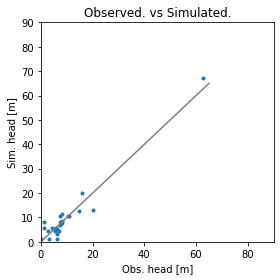

Error is - 2.998977585050149
Params are - [7.12505771e-01 1.57730017e+01 1.54661001e+01 5.05129324e-01
 1.03893020e+00 5.07177292e-01 2.07786040e-03 7.32719758e-01
 1.66701468e-01 3.06262394e-01 1.80986410e-03 3.72525314e+00]


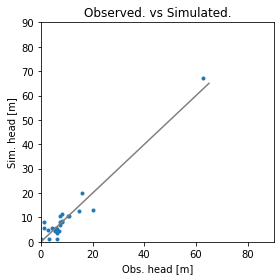

Error is - 2.9966492555892277
Params are - [7.07784510e-01 1.55796131e+01 1.63104501e+01 5.01123100e-01
 1.03569635e+00 5.03512396e-01 2.07139269e-03 7.22548050e-01
 1.72998934e-01 3.04389459e-01 1.79400812e-03 3.68467033e+00]


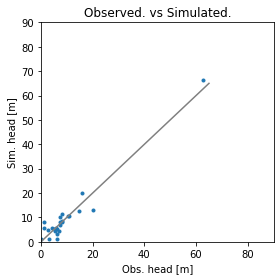

Error is - 2.958145833266862
Params are - [7.08760099e-01 1.53027530e+01 1.68656752e+01 4.99601317e-01
 1.04937785e+00 5.03185261e-01 2.09875570e-03 7.05697076e-01
 1.73790068e-01 3.05334189e-01 1.78351218e-03 3.63638049e+00]


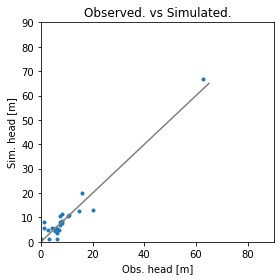

Error is - 2.983048135056489
Params are - [7.15077860e-01 1.55967387e+01 1.56547293e+01 5.05223320e-01
 9.93925988e-01 5.08209940e-01 2.10451864e-03 7.21414230e-01
 1.75047279e-01 3.07778491e-01 1.80626015e-03 3.69698374e+00]


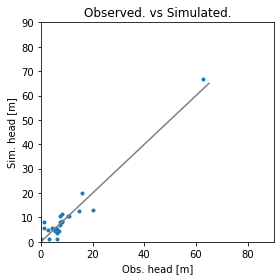

Error is - 2.967138553835682
Params are - [7.09651022e-01 1.53480469e+01 1.57527397e+01 5.00422577e-01
 1.03157106e+00 5.03906967e-01 2.09925323e-03 7.59184657e-01
 1.73960252e-01 3.05672128e-01 1.78688684e-03 3.64561297e+00]


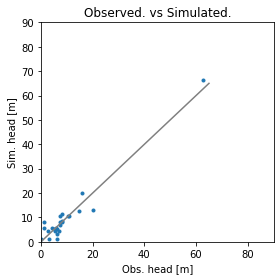

Error is - 2.956954198348606
Params are - [7.08801964e-01 1.62721042e+01 1.57596779e+01 4.98737605e-01
 1.03332210e+00 5.02802727e-01 2.10877383e-03 7.30130942e-01
 1.74023457e-01 3.05564242e-01 1.77838187e-03 3.61504963e+00]


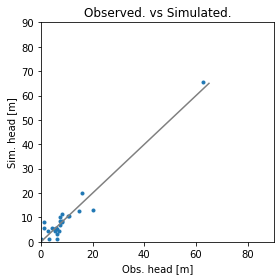

Error is - 2.914447223486204
Params are - [7.09233038e-01 1.67840822e+01 1.57172946e+01 4.95270759e-01
 1.04431186e+00 5.01368442e-01 2.15181816e-03 7.22713775e-01
 1.75071065e-01 3.06644974e-01 1.75736446e-03 3.52630708e+00]


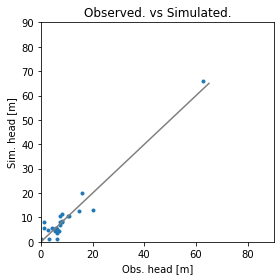

Error is - 2.939239197733985
Params are - [7.07473648e-01 1.57409532e+01 1.57687331e+01 4.95901430e-01
 1.03661147e+00 5.00982832e-01 2.12588499e-03 7.27401332e-01
 1.74172325e-01 3.05442957e-01 1.76390326e-03 3.81761605e+00]


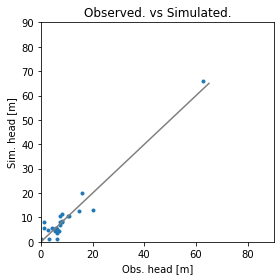

Error is - 2.929404664963015
Params are - [7.05374241e-01 1.57256423e+01 1.57957236e+01 4.92829039e-01
 1.03793479e+00 4.98757341e-01 2.13730863e-03 7.25755997e-01
 1.74055352e-01 3.04916539e-01 1.74928567e-03 3.67120872e+00]


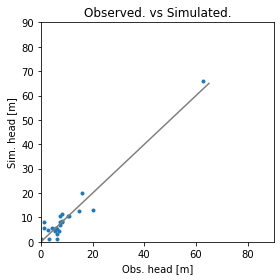

Error is - 2.920317962361836
Params are - [7.02367431e-01 1.57124234e+01 1.58381350e+01 4.88846366e-01
 1.03868224e+00 4.95762720e-01 2.14904336e-03 7.24189959e-01
 1.73783490e-01 3.04063455e-01 1.85329824e-03 3.66162073e+00]


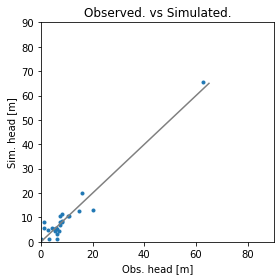

Error is - 2.9127404360649574
Params are - [6.98209067e-01 1.57024193e+01 1.59003579e+01 5.17763108e-01
 1.03862508e+00 4.91804409e-01 2.16087552e-03 7.22775351e-01
 1.73308359e-01 3.02789439e-01 1.78339039e-03 3.65102540e+00]


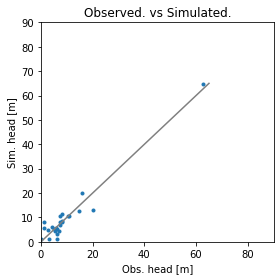

Error is - 2.8755734821278187
Params are - [6.89958856e-01 1.56148930e+01 1.59946298e+01 5.35974607e-01
 1.04743084e+00 4.82453225e-01 2.22029973e-03 7.13826749e-01
 1.73176386e-01 3.01032125e-01 1.77242339e-03 3.60821696e+00]


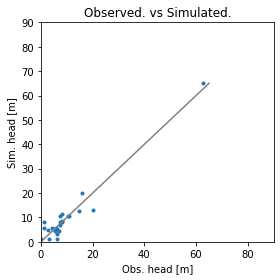

Error is - 2.899657476444852
Params are - [6.91223783e-01 1.56824811e+01 1.60035300e+01 5.01330502e-01
 1.03894199e+00 5.19113610e-01 2.18241569e-03 7.20114720e-01
 1.72547758e-01 3.00684991e-01 1.77687159e-03 3.63221852e+00]


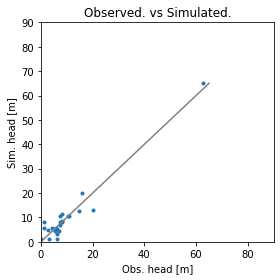

Error is - 2.8944065161965664
Params are - [7.31202917e-01 1.56811818e+01 1.61255300e+01 5.00385818e-01
 1.03657939e+00 4.99238487e-01 2.19511244e-03 7.19063458e-01
 1.71467386e-01 2.98143277e-01 1.77077371e-03 3.61821584e+00]


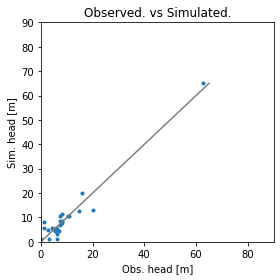

Error is - 2.887442569209361
Params are - [7.03085546e-01 1.56882695e+01 1.62880986e+01 4.99089280e-01
 1.03234754e+00 4.97207388e-01 2.20697434e-03 7.18491921e-01
 1.69956118e-01 3.15151964e-01 1.76328565e-03 3.60281731e+00]


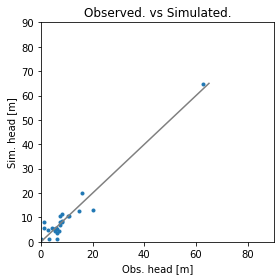

Error is - 2.879929381752552
Params are - [6.99728970e-01 1.57065758e+01 1.65013697e+01 4.97349845e-01
 1.02568897e+00 4.94520410e-01 2.21737042e-03 7.18589221e-01
 1.79469779e-01 3.02881788e-01 1.75411342e-03 3.58594660e+00]


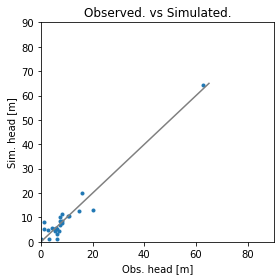

Error is - 2.8675740765290993
Params are - [7.12189569e-01 1.54306735e+01 1.60510314e+01 5.02037476e-01
 1.06890067e+00 5.00784437e-01 2.21479256e-03 6.96073849e-01
 1.77749543e-01 3.09624480e-01 1.75632976e-03 3.53385750e+00]


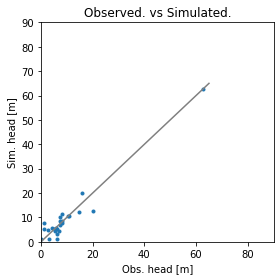

Error is - 2.849589393618502
Params are - [7.18284353e-01 1.51460102e+01 1.60765472e+01 5.03056215e-01
 1.10335100e+00 5.01176656e-01 2.27218883e-03 6.69110773e-01
 1.81624315e-01 3.14436720e-01 1.73449464e-03 3.42578625e+00]


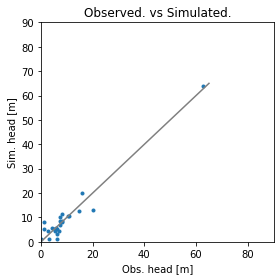

Error is - 2.8588826807317553
Params are - [6.97646124e-01 1.57588134e+01 1.64666051e+01 4.96452973e-01
 1.09321218e+00 4.91402283e-01 2.23821894e-03 7.15942377e-01
 1.73798437e-01 3.02955694e-01 1.73810869e-03 3.54167418e+00]


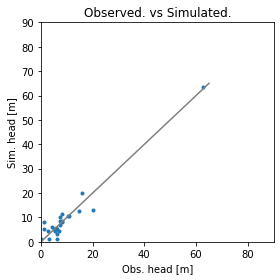

Error is - 2.854629685309571
Params are - [7.01072146e-01 1.60759662e+01 1.64875722e+01 5.00592115e-01
 1.06584063e+00 4.93621142e-01 2.26664531e-03 6.70964903e-01
 1.74858495e-01 3.04609317e-01 1.74935231e-03 3.57572181e+00]


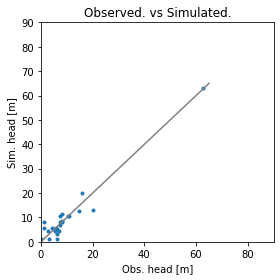

Error is - 2.8504272067823
Params are - [7.00681744e-01 1.62501290e+01 1.53116197e+01 5.01578508e-01
 1.05077763e+00 4.92748828e-01 2.29512443e-03 7.18663788e-01
 1.75206750e-01 3.04826444e-01 1.74703366e-03 3.57484452e+00]


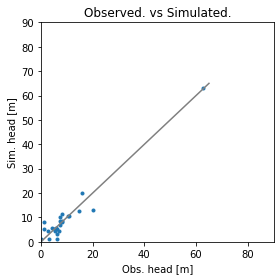

Error is - 2.8488087138972396
Params are - [7.00836210e-01 1.58967914e+01 1.63323761e+01 5.06224574e-01
 1.06590504e+00 4.93578923e-01 2.29620173e-03 6.95503274e-01
 1.74996896e-01 3.04614924e-01 1.76383098e-03 3.35314704e+00]


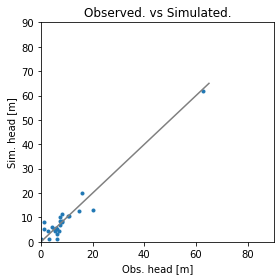

Error is - 2.849643707722927
Params are - [6.97517491e-01 1.59747105e+01 1.66141976e+01 5.11386147e-01
 1.08055182e+00 4.89876969e-01 2.38136010e-03 6.79554245e-01
 1.75409182e-01 3.04200908e-01 1.76379484e-03 3.12091254e+00]


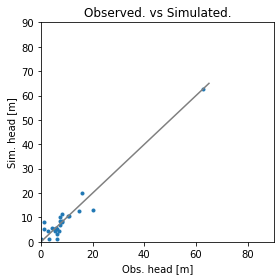

Error is - 2.8468000821567965
Params are - [7.02179278e-01 1.59406272e+01 1.63948277e+01 5.11529555e-01
 1.06924342e+00 4.94941344e-01 2.31126027e-03 6.92106489e-01
 1.75270793e-01 3.05091073e-01 1.78087279e-03 3.44654408e+00]


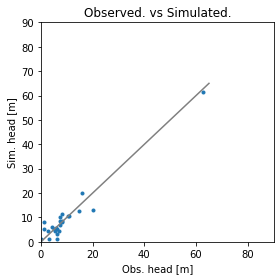

Error is - 2.8528659514761983
Params are - [7.00581797e-01 1.60481197e+01 1.66943798e+01 5.20879813e-01
 1.08489774e+00 4.93033345e-01 2.39823608e-03 6.75281734e-01
 1.75878514e-01 3.05178341e-01 1.79666635e-03 3.33421177e+00]


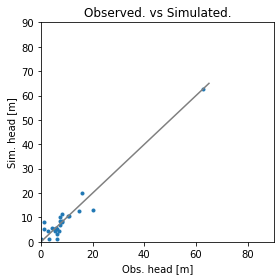

Error is - 2.8466550514482742
Params are - [7.05154730e-01 1.59918800e+01 1.64451984e+01 5.19292759e-01
 1.07358951e+00 4.97799070e-01 2.32656169e-03 6.88325283e-01
 1.75790539e-01 3.06115427e-01 1.66478931e-03 3.42028597e+00]


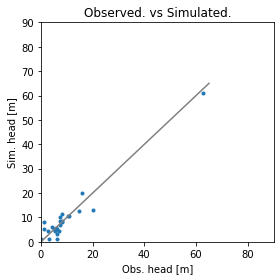

Error is - 2.86040008637471
Params are - [7.06548379e-01 1.61316084e+01 1.67487301e+01 5.34515955e-01
 1.09104315e+00 4.98817245e-01 2.41532086e-03 6.70392945e-01
 1.76794064e-01 3.07141413e-01 1.57053485e-03 3.29961858e+00]


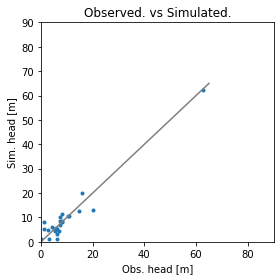

Error is - 2.8448636370134137
Params are - [6.97609405e-01 1.47881876e+01 1.66873562e+01 5.16872033e-01
 1.07283950e+00 4.91598452e-01 2.35291082e-03 6.84070051e-01
 1.74622877e-01 3.03445650e-01 1.74529389e-03 3.53792943e+00]


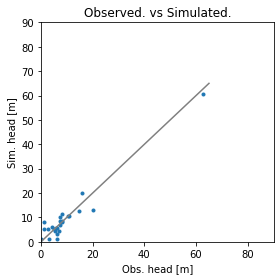

Error is - 2.86341454674915
Params are - [6.91797588e-01 1.37902404e+01 1.71723870e+01 5.27672669e-01
 1.08710333e+00 4.86713458e-01 2.45345715e-03 6.64748190e-01
 1.74398783e-01 3.01845987e-01 1.73925860e-03 3.54374061e+00]


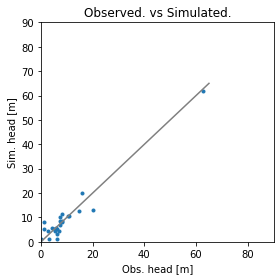

Error is - 2.84782997411309
Params are - [7.16682930e-01 1.57407398e+01 1.65150918e+01 5.13402544e-01
 1.08385895e+00 4.69267425e-01 2.35072913e-03 6.80661661e-01
 1.77492037e-01 3.09865743e-01 1.72052382e-03 3.41630315e+00]


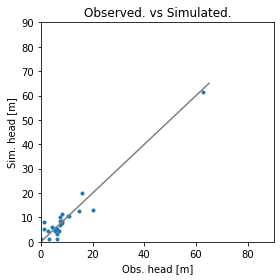

Error is - 2.852932374836887
Params are - [6.74283798e-01 1.57519654e+01 1.64580188e+01 5.16516683e-01
 1.09410148e+00 4.84147371e-01 2.36396850e-03 6.75312624e-01
 1.79576518e-01 3.14361201e-01 1.71824672e-03 3.39665371e+00]


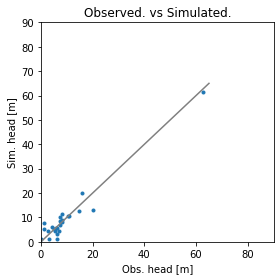

Error is - 2.8589718254062997
Params are - [6.97600878e-01 1.57554937e+01 1.63237702e+01 5.20717789e-01
 1.10862565e+00 4.84001800e-01 2.37827229e-03 6.68687611e-01
 1.82691185e-01 2.97220721e-01 1.71822828e-03 3.37769165e+00]


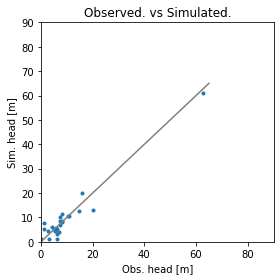

Error is - 2.858715100240379
Params are - [7.00602772e-01 1.57453404e+01 1.60808991e+01 5.26351881e-01
 1.12910700e+00 4.84935677e-01 2.39469320e-03 6.60273376e-01
 1.73714426e-01 3.08547385e-01 1.72141966e-03 3.35985320e+00]


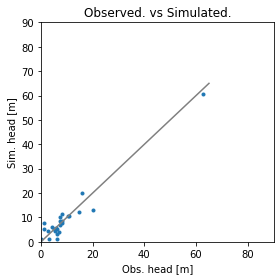

Error is - 2.8722672591697638
Params are - [7.12146872e-01 1.58587644e+01 1.66020173e+01 4.86123331e-01
 1.12097782e+00 4.97416604e-01 2.42082946e-03 6.56110286e-01
 1.80097492e-01 3.11649591e-01 1.69460907e-03 3.29618887e+00]


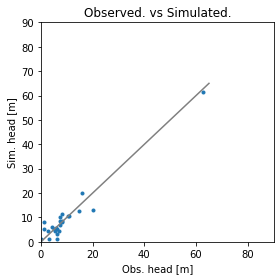

Error is - 2.8532268778776024
Params are - [7.06599868e-01 1.57977966e+01 1.64501704e+01 4.98586150e-01
 1.10259108e+00 4.93675759e-01 2.37069703e-03 6.70539402e-01
 1.78367216e-01 3.08995225e-01 1.71406265e-03 3.37419589e+00]


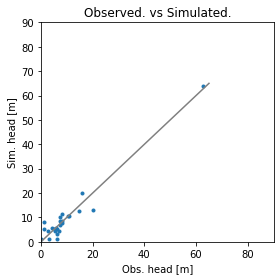

Error is - 2.8571189369949255
Params are - [7.06004681e-01 1.57252142e+01 1.62939436e+01 4.97691543e-01
 1.05877725e+00 4.97480355e-01 2.26159435e-03 7.01558056e-01
 1.69862031e-01 3.17423413e-01 1.74810990e-03 3.52613156e+00]


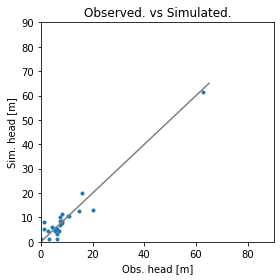

Error is - 2.8536303373505305
Params are - [7.07352528e-01 1.57162946e+01 1.61223317e+01 5.22162787e-01
 1.06845157e+00 4.91092884e-01 2.40554360e-03 6.51905904e-01
 1.78098712e-01 3.14099727e-01 1.72989636e-03 3.35955859e+00]


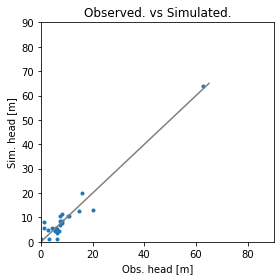

Error is - 2.8662425145677717
Params are - [7.05520839e-01 1.57249266e+01 1.65149431e+01 4.91565697e-01
 1.02244751e+00 4.98585692e-01 2.25087775e-03 7.06180325e-01
 1.78913438e-01 3.09433426e-01 1.74799818e-03 3.54133047e+00]


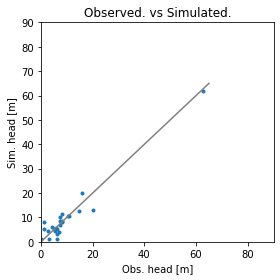

Error is - 2.848664931663216
Params are - [7.01832289e-01 1.57402370e+01 1.61894101e+01 5.17655335e-01
 1.10244213e+00 4.88348180e-01 2.35873934e-03 6.71750113e-01
 1.75014179e-01 3.08768895e-01 1.72806429e-03 3.40522251e+00]


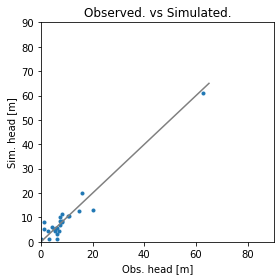

Error is - 2.8633764373589763
Params are - [6.99423532e-01 1.57475567e+01 1.62844765e+01 5.23553333e-01
 1.10005474e+00 4.84518984e-01 2.40016743e-03 6.59927655e-01
 1.83624524e-01 2.99114978e-01 1.71796700e-03 3.35490060e+00]


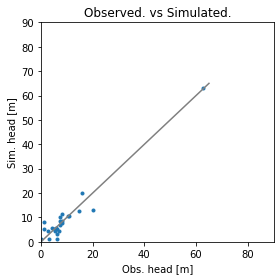

Error is - 2.847831455663407
Params are - [7.04359394e-01 1.57307998e+01 1.62915768e+01 5.04156990e-01
 1.06909662e+00 4.94240012e-01 2.29623762e-03 6.91150456e-01
 1.73302654e-01 3.12846304e-01 1.74057418e-03 3.48332382e+00]


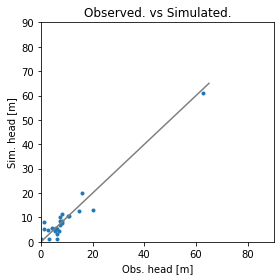

Error is - 2.857064203157719
Params are - [7.04903942e-01 1.53392769e+01 1.60581819e+01 5.21246907e-01
 1.09353403e+00 4.88481342e-01 2.40004853e-03 6.93885067e-01
 1.78368753e-01 3.13301905e-01 1.71526157e-03 3.28991068e+00]


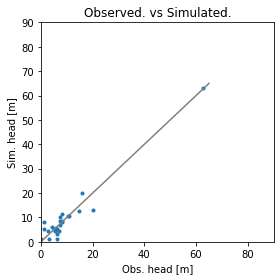

Error is - 2.847764817559186
Params are - [7.02030095e-01 1.58917939e+01 1.63802246e+01 5.05755813e-01
 1.07276398e+00 4.92336192e-01 2.29999611e-03 6.76694944e-01
 1.75736060e-01 3.06782464e-01 1.74082963e-03 3.50426903e+00]


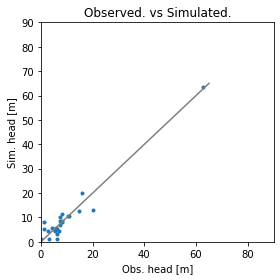

Error is - 2.857340213376698
Params are - [6.97736487e-01 1.57281984e+01 1.64664046e+01 4.96941739e-01
 1.09164182e+00 4.91216818e-01 2.24355898e-03 7.17075573e-01
 1.74734760e-01 3.02591952e-01 1.73653973e-03 3.53019231e+00]


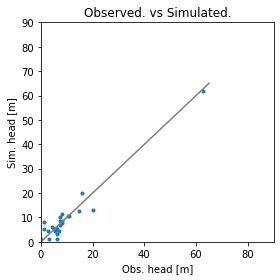

Error is - 2.8477738996991624
Params are - [7.04948518e-01 1.57192705e+01 1.62083499e+01 5.15857525e-01
 1.07424913e+00 4.91123867e-01 2.36504745e-03 6.68198321e-01
 1.77257724e-01 3.11222783e-01 1.73155720e-03 3.40221702e+00]


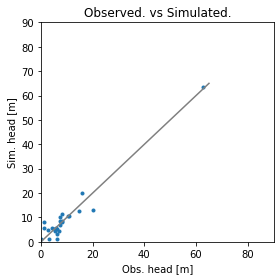

Error is - 2.852999697305916
Params are - [6.98213923e-01 1.56336088e+01 1.60982625e+01 5.23396939e-01
 1.05277865e+00 4.88208628e-01 2.27746396e-03 6.98051894e-01
 1.74281342e-01 3.08067713e-01 1.75528920e-03 3.52022520e+00]


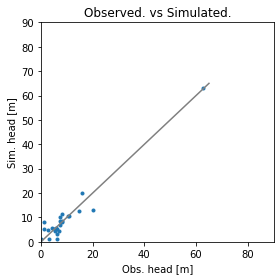

Error is - 2.8476282593513105
Params are - [7.00310409e-01 1.56746557e+01 1.61862395e+01 5.17194242e-01
 1.06523176e+00 4.89575411e-01 2.30077223e-03 6.91173771e-01
 1.75302810e-01 3.08299591e-01 1.74498256e-03 3.48371787e+00]


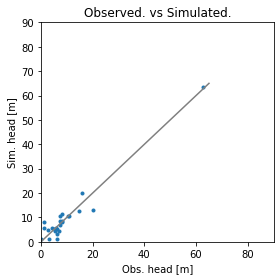

Error is - 2.853902255748191
Params are - [7.34867761e-01 1.56665550e+01 1.60451176e+01 5.05579332e-01
 1.05645664e+00 4.98641689e-01 2.27365978e-03 6.95922197e-01
 1.72359754e-01 3.01691469e-01 1.75556111e-03 3.51227807e+00]


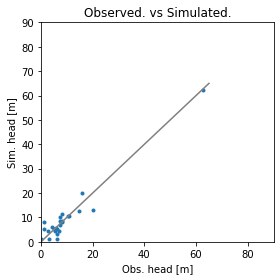

Error is - 2.847690586516233
Params are - [6.89429789e-01 1.57306128e+01 1.63547935e+01 5.13782345e-01
 1.08469027e+00 4.87770951e-01 2.34139132e-03 6.80465017e-01
 1.77772327e-01 3.11193768e-01 1.72757531e-03 3.42555980e+00]


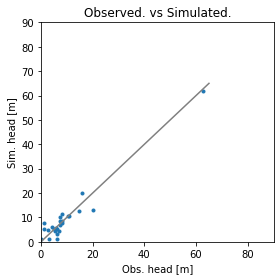

Error is - 2.849593706897468
Params are - [7.06594490e-01 1.50818054e+01 1.73653790e+01 5.22551480e-01
 1.10543259e+00 4.89210586e-01 2.35021499e-03 6.46204571e-01
 1.77157119e-01 3.12287446e-01 1.72353110e-03 3.30920648e+00]


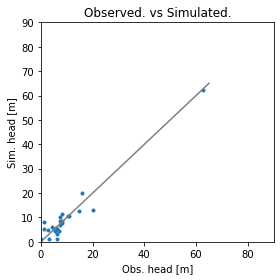

Error is - 2.846800260176122
Params are - [7.05116303e-01 1.53738863e+01 1.68519392e+01 5.17308237e-01
 1.09176885e+00 4.90095146e-01 2.33644235e-03 6.64319375e-01
 1.76669527e-01 3.10422196e-01 1.72940674e-03 3.37561599e+00]


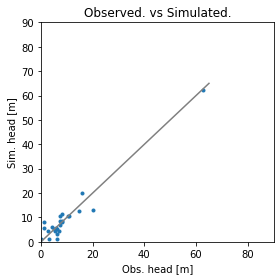

Error is - 2.845360283077512
Params are - [6.86797206e-01 1.62239035e+01 1.67296835e+01 5.23449111e-01
 1.05092886e+00 4.78935840e-01 2.38385951e-03 6.94959019e-01
 1.69913756e-01 3.02008083e-01 1.73522215e-03 3.44990303e+00]


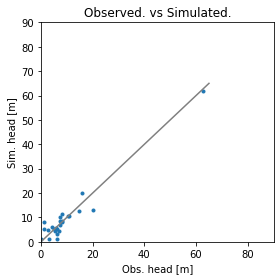

Error is - 2.849205079627355
Params are - [7.01905514e-01 1.55276409e+01 1.65400724e+01 5.23151507e-01
 1.08587879e+00 4.84093059e-01 2.37445624e-03 6.68475809e-01
 1.75693984e-01 3.11395405e-01 1.70111767e-03 3.53866824e+00]


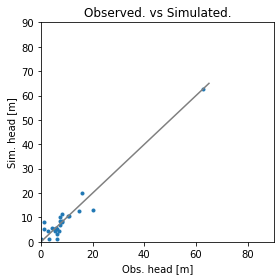

Error is - 2.84633988127146
Params are - [7.01103536e-01 1.58045038e+01 1.63843002e+01 5.10456308e-01
 1.07089848e+00 4.91207457e-01 2.31576536e-03 6.88746408e-01
 1.75171168e-01 3.06310045e-01 1.74815265e-03 3.39952734e+00]


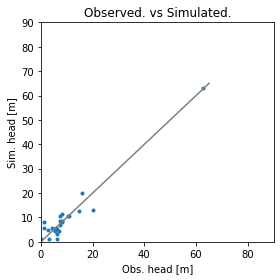

Error is - 2.8496663786123744
Params are - [7.00787976e-01 1.56949065e+01 1.67155201e+01 5.10520909e-01
 1.04408443e+00 4.89800348e-01 2.30475631e-03 6.95061686e-01
 1.75702867e-01 3.06831626e-01 1.74023242e-03 3.48564358e+00]


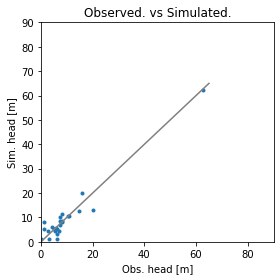

Error is - 2.8463052832206555
Params are - [7.01571211e-01 1.57289044e+01 1.63209376e+01 5.15871728e-01
 1.08785270e+00 4.88711222e-01 2.34524358e-03 6.77578006e-01
 1.75186351e-01 3.08284578e-01 1.73110632e-03 3.42532778e+00]


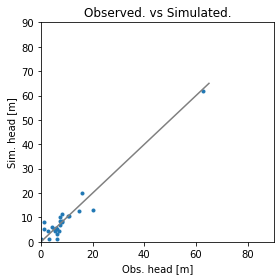

Error is - 2.8501024478282915
Params are - [6.97796174e-01 1.57040278e+01 1.66182469e+01 5.25971709e-01
 1.08055595e+00 4.82987051e-01 2.37542568e-03 6.73399269e-01
 1.77728341e-01 3.01993929e-01 1.72614455e-03 3.39787626e+00]


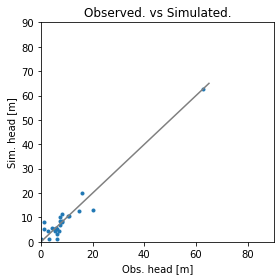

Error is - 2.84590730825822
Params are - [7.02718589e-01 1.57241068e+01 1.63732443e+01 5.09610670e-01
 1.07196145e+00 4.91426772e-01 2.31603464e-03 6.86712659e-01
 1.74409076e-01 3.10133211e-01 1.73696677e-03 3.46196193e+00]


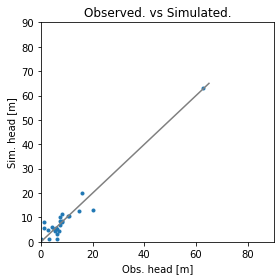

Error is - 2.8463779542634877
Params are - [6.83145248e-01 1.56913156e+01 1.63710907e+01 5.16094177e-01
 1.06381070e+00 5.11652863e-01 2.31515175e-03 6.84896563e-01
 1.73025131e-01 3.05019069e-01 1.74893541e-03 3.47250673e+00]


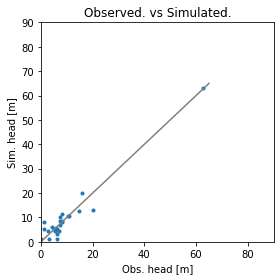

Error is - 2.849367515826484
Params are - [6.91245782e-01 1.57081257e+01 1.67049559e+01 5.13678638e-01
 1.07168078e+00 4.93217919e-01 2.29251749e-03 7.00142943e-01
 1.72554012e-01 3.02628076e-01 1.74079839e-03 3.49830781e+00]


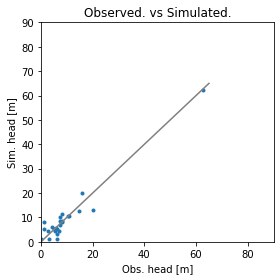

Error is - 2.8459573324966527
Params are - [7.01522834e-01 1.57164843e+01 1.63325014e+01 5.15312803e-01
 1.07360704e+00 4.91647380e-01 2.34691496e-03 6.76184477e-01
 1.76081796e-01 3.09074106e-01 1.73386750e-03 3.42623972e+00]


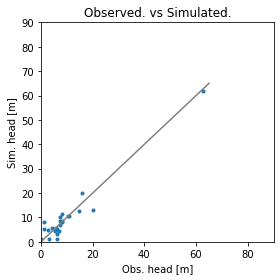

Error is - 2.845926623213012
Params are - [6.94079661e-01 1.55063841e+01 1.65251274e+01 5.25373181e-01
 1.07330645e+00 4.91890793e-01 2.36538863e-03 6.91561243e-01
 1.74133299e-01 3.07450335e-01 1.73036561e-03 3.38325092e+00]


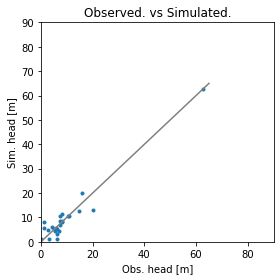

Error is - 2.8451553596092
Params are - [7.07454946e-01 1.56301938e+01 1.65789475e+01 5.19278455e-01
 1.05948286e+00 4.97142674e-01 2.32799298e-03 6.89640540e-01
 1.71490527e-01 3.02415126e-01 1.74408497e-03 3.45490866e+00]


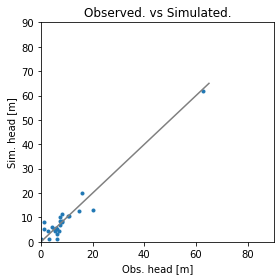

Error is - 2.846660325440655
Params are - [6.97765082e-01 1.56787405e+01 1.68129529e+01 5.16213928e-01
 1.07798321e+00 4.96599425e-01 2.37314886e-03 6.78676247e-01
 1.73324663e-01 3.04328559e-01 1.72652812e-03 3.39194906e+00]


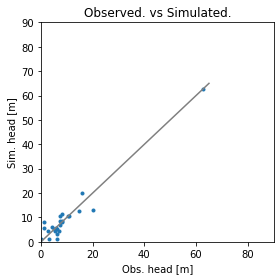

Error is - 2.8452495725878535
Params are - [6.91733985e-01 1.60303190e+01 1.61407555e+01 5.15917547e-01
 1.04914852e+00 4.97163736e-01 2.34359649e-03 7.07923456e-01
 1.71400469e-01 3.01190348e-01 1.74162417e-03 3.50277312e+00]


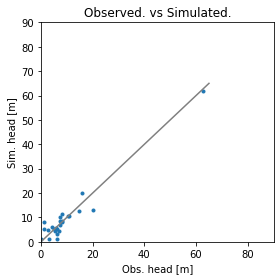

Error is - 2.8454328556810777
Params are - [6.92930127e-01 1.54785267e+01 1.65555216e+01 5.22427562e-01
 1.06832479e+00 4.92687937e-01 2.37416794e-03 6.82772503e-01
 1.72154149e-01 3.05871349e-01 1.68361669e-03 3.44121653e+00]


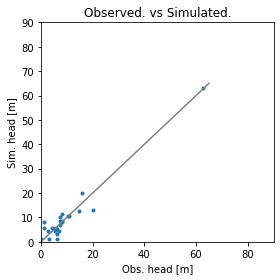

Error is - 2.8468373202160406
Params are - [6.96538497e-01 1.57070444e+01 1.60944912e+01 5.18778794e-01
 1.05797527e+00 4.90377941e-01 2.31244920e-03 6.96885454e-01
 1.73905193e-01 3.06890996e-01 1.73080945e-03 3.50402280e+00]


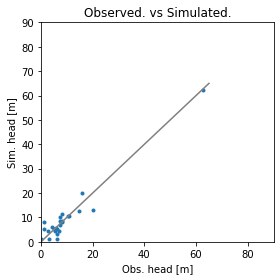

Error is - 2.845355973821015
Params are - [6.97458436e-01 1.56858165e+01 1.66333375e+01 5.16855144e-01
 1.07298122e+00 4.95044054e-01 2.35797394e-03 6.83228549e-01
 1.73469796e-01 3.04969168e-01 1.72759845e-03 3.41996750e+00]


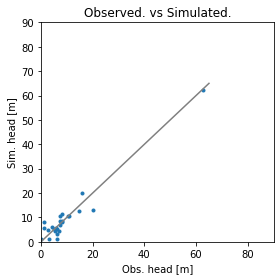

Error is - 2.843565128066888
Params are - [6.87866134e-01 1.53428943e+01 1.64936021e+01 5.15293695e-01
 1.06226758e+00 4.88719127e-01 2.36427174e-03 6.86386963e-01
 1.71052526e-01 3.04913084e-01 1.80301645e-03 3.47563282e+00]


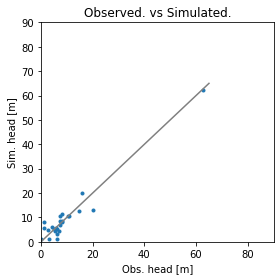

Error is - 2.842806657602093
Params are - [6.79221837e-01 1.50184014e+01 1.65178040e+01 5.13294163e-01
 1.05660662e+00 4.84179155e-01 2.38312676e-03 6.85417803e-01
 1.68683520e-01 3.04311913e-01 1.87213002e-03 3.50330624e+00]


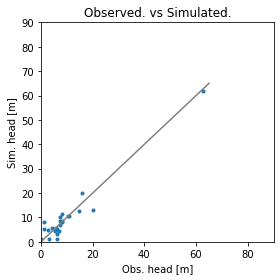

Error is - 2.8469758850950924
Params are - [7.09221714e-01 1.55313064e+01 1.65921621e+01 5.18025607e-01
 1.07084571e+00 4.70286383e-01 2.38701085e-03 6.89902556e-01
 1.73094333e-01 3.05891583e-01 1.73940279e-03 3.42854530e+00]


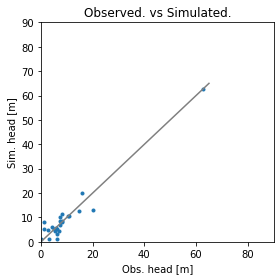

Error is - 2.8449307979685834
Params are - [6.89664365e-01 1.56513133e+01 1.64263585e+01 5.16577034e-01
 1.06556945e+00 5.01311243e-01 2.33311653e-03 6.86148061e-01
 1.73042431e-01 3.05237197e-01 1.74655225e-03 3.46151637e+00]


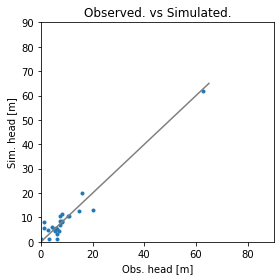

Error is - 2.8448780916821104
Params are - [6.89356897e-01 1.53925864e+01 1.65859623e+01 5.24683598e-01
 1.06286977e+00 4.92415753e-01 2.38928911e-03 6.85619653e-01
 1.70593506e-01 3.04421800e-01 1.73991882e-03 3.51185620e+00]


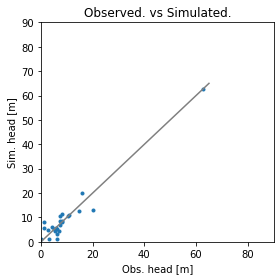

Error is - 2.8437990117289833
Params are - [6.86853504e-01 1.54121329e+01 1.66934957e+01 5.20736822e-01
 1.04175172e+00 4.95529409e-01 2.36715180e-03 6.98128329e-01
 1.69812849e-01 3.01803470e-01 1.75843389e-03 3.50047716e+00]


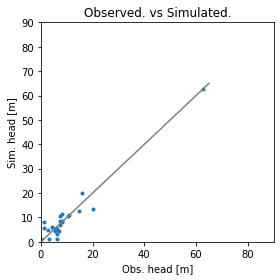

Error is - 2.8433769832356885
Params are - [6.84456992e-01 1.53738277e+01 1.67420975e+01 5.22199750e-01
 1.05068816e+00 4.93240256e-01 2.36885323e-03 7.03179168e-01
 1.67872580e-01 2.99802169e-01 1.75976712e-03 3.51193813e+00]


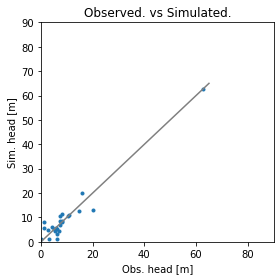

Error is - 2.844309466287797
Params are - [6.90296387e-01 1.55618351e+01 1.65856333e+01 5.11610467e-01
 1.04721904e+00 4.93221754e-01 2.35095699e-03 6.89738722e-01
 1.68777623e-01 3.00151245e-01 1.76816926e-03 3.57637480e+00]


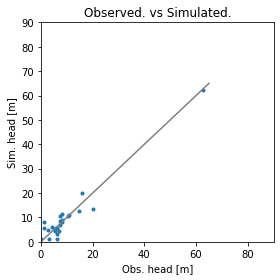

Error is - 2.8449597363828167
Params are - [6.79587092e-01 1.53170672e+01 1.67729145e+01 5.27706277e-01
 1.04444030e+00 4.93984939e-01 2.40613138e-03 6.95091650e-01
 1.67563271e-01 2.95804709e-01 1.76676851e-03 3.51673260e+00]


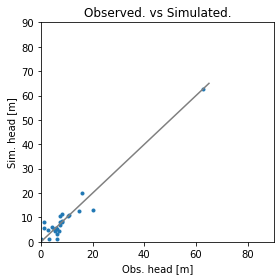

Error is - 2.844419033172955
Params are - [6.87151715e-01 1.55357374e+01 1.66268694e+01 5.15769172e-01
 1.04409621e+00 4.92939941e-01 2.35332531e-03 7.01084997e-01
 1.69053052e-01 2.98388797e-01 1.83397723e-03 3.55006401e+00]


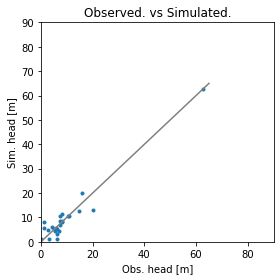

Error is - 2.8435062357041656
Params are - [6.93343721e-01 1.46756663e+01 1.64355719e+01 5.13467633e-01
 1.06035337e+00 5.09026054e-01 2.33854471e-03 6.89919477e-01
 1.71149994e-01 3.01648848e-01 1.79883095e-03 3.55807101e+00]


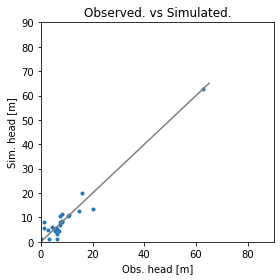

Error is - 2.8450579500602533
Params are - [6.81996705e-01 1.50453949e+01 1.64989569e+01 5.19497014e-01
 1.03619636e+00 4.95248174e-01 2.36119207e-03 7.02765102e-01
 1.67207321e-01 2.98134377e-01 1.81832672e-03 3.61102380e+00]


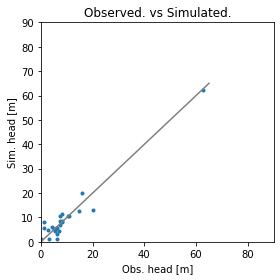

Error is - 2.842748555659542
Params are - [6.86098276e-01 1.45367383e+01 1.70512392e+01 5.21031189e-01
 1.05787038e+00 4.92809232e-01 2.37850213e-03 6.77210470e-01
 1.68577789e-01 3.01403869e-01 1.81708477e-03 3.54625995e+00]


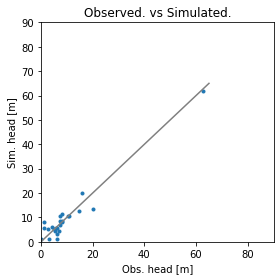

Error is - 2.84344715938671
Params are - [6.83280422e-01 1.37899480e+01 1.75064810e+01 5.23588010e-01
 1.06223131e+00 4.90631980e-01 2.39595495e-03 6.61853977e-01
 1.67166449e-01 3.01510629e-01 1.85481506e-03 3.56800336e+00]


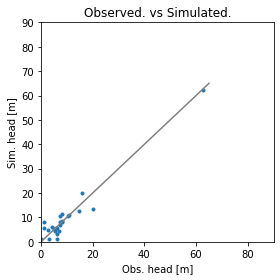

Error is - 2.8437374932269996
Params are - [6.66817870e-01 1.47546210e+01 1.66917624e+01 5.17962403e-01
 1.04726729e+00 4.92108053e-01 2.40252383e-03 6.93421707e-01
 1.68002276e-01 3.00010548e-01 1.82679060e-03 3.60934962e+00]


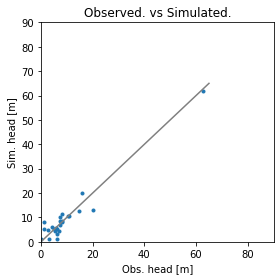

Error is - 2.845500714640283
Params are - [6.89746305e-01 1.52909576e+01 1.68038872e+01 5.17488076e-01
 1.07239894e+00 4.93479200e-01 2.37621336e-03 6.78739913e-01
 1.72417974e-01 3.04603992e-01 1.75395949e-03 3.45295546e+00]


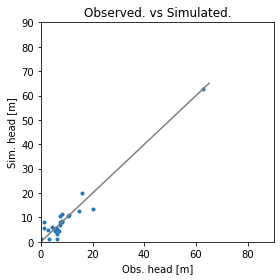

Error is - 2.843227220739237
Params are - [6.83934105e-01 1.51067855e+01 1.65751895e+01 5.18994779e-01
 1.04524701e+00 4.94805930e-01 2.36494740e-03 6.96758805e-01
 1.68509984e-01 2.99751781e-01 1.80223492e-03 3.57150671e+00]


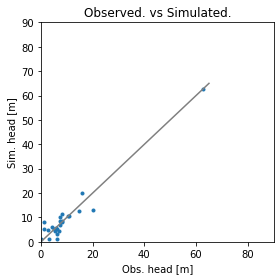

Error is - 2.844475839637306
Params are - [6.92880420e-01 1.49842383e+01 1.64969754e+01 5.07826896e-01
 1.06428945e+00 4.94879267e-01 2.32441006e-03 6.86691224e-01
 1.72219809e-01 3.07591505e-01 1.81142877e-03 3.55637567e+00]


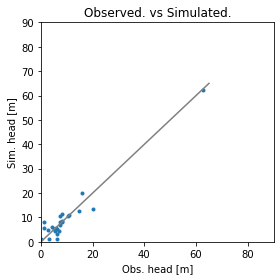

Error is - 2.843649697885603
Params are - [6.83339157e-01 1.45388130e+01 1.68553009e+01 5.17497783e-01
 1.04294697e+00 4.86480967e-01 2.39597383e-03 6.95725340e-01
 1.66603545e-01 2.98551401e-01 1.84245779e-03 3.62740178e+00]


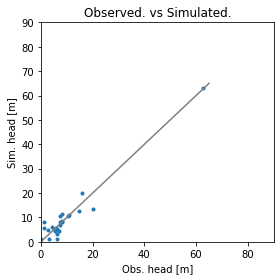

Error is - 2.845262479081163
Params are - [6.82643667e-01 1.46552443e+01 1.67405869e+01 5.08193584e-01
 1.04232618e+00 4.94387326e-01 2.34091537e-03 6.97938029e-01
 1.68387477e-01 2.98388400e-01 1.86618105e-03 3.59631956e+00]


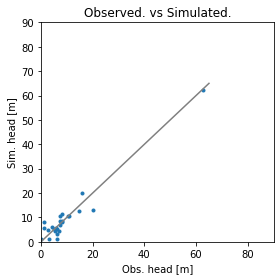

Error is - 2.8434771423926817
Params are - [6.87678590e-01 1.52082509e+01 1.66246185e+01 5.20561094e-01
 1.05773387e+00 4.92908646e-01 2.37719567e-03 6.88699247e-01
 1.70041999e-01 3.02913450e-01 1.77148437e-03 3.53297204e+00]


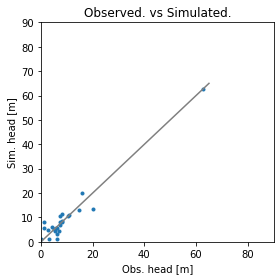

Error is - 2.8461138148784704
Params are - [6.72736024e-01 1.53296537e+01 1.66287368e+01 5.16619993e-01
 1.02983885e+00 4.95422992e-01 2.38134114e-03 7.00259164e-01
 1.63594627e-01 2.99275849e-01 1.86517106e-03 3.56942009e+00]


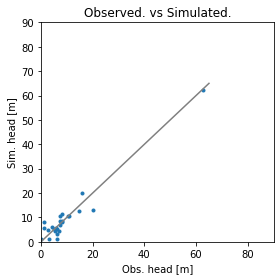

Error is - 2.8436867298409014
Params are - [6.91391060e-01 1.49235541e+01 1.66727013e+01 5.16809023e-01
 1.06208934e+00 4.92554587e-01 2.36001840e-03 6.88117329e-01
 1.71865814e-01 3.02403200e-01 1.77526318e-03 3.54580210e+00]


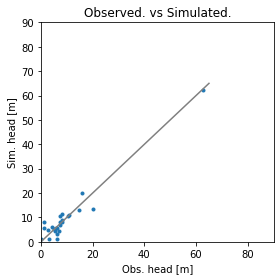

Error is - 2.846309677605685
Params are - [6.77216782e-01 1.51234890e+01 1.68484051e+01 5.27162150e-01
 1.03802221e+00 4.91754731e-01 2.41577662e-03 6.97875675e-01
 1.65938695e-01 2.94265276e-01 1.79300857e-03 3.54921159e+00]


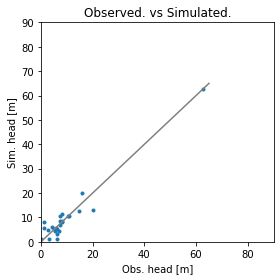

Error is - 2.8434014745267517
Params are - [6.88964511e-01 1.50190510e+01 1.65848329e+01 5.12660710e-01
 1.05772264e+00 4.94098133e-01 2.34725170e-03 6.89487337e-01
 1.70649531e-01 3.04259948e-01 1.80682372e-03 3.55458465e+00]


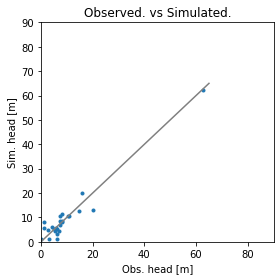

Error is - 2.8434113558214382
Params are - [6.83247620e-01 1.44858755e+01 1.67115051e+01 5.18701797e-01
 1.06048652e+00 4.93887088e-01 2.38584910e-03 6.81548959e-01
 1.69371532e-01 3.04446510e-01 1.76593454e-03 3.55627669e+00]


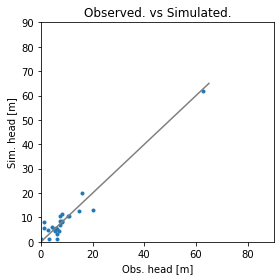

Error is - 2.843964345046124
Params are - [6.78928154e-01 1.42804511e+01 1.67737198e+01 5.24042391e-01
 1.05957494e+00 4.93716164e-01 2.39403277e-03 6.91530273e-01
 1.69745945e-01 3.03399939e-01 1.83137005e-03 3.52661621e+00]


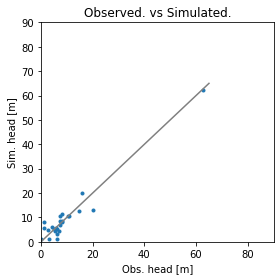

Error is - 2.843137863355861
Params are - [6.81770212e-01 1.46007971e+01 1.67266982e+01 5.20934410e-01
 1.05648597e+00 4.93592562e-01 2.38326382e-03 6.91082385e-01
 1.69503865e-01 3.02587766e-01 1.81556986e-03 3.53905586e+00]


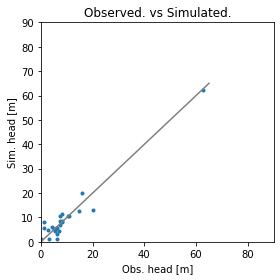

Error is - 2.8429576286941787
Params are - [6.81523821e-01 1.42949308e+01 1.66713912e+01 5.14948967e-01
 1.06749797e+00 4.91085701e-01 2.38052329e-03 6.81966342e-01
 1.68659222e-01 3.01878430e-01 1.85062808e-03 3.60894364e+00]


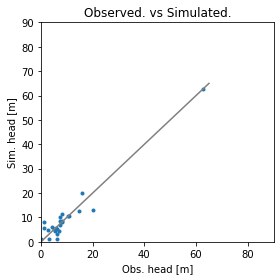

Error is - 2.843163889021302
Params are - [7.04010447e-01 1.48758276e+01 1.66697293e+01 5.17221146e-01
 1.06535418e+00 4.94336666e-01 2.34148451e-03 6.84763736e-01
 1.70579287e-01 3.03982666e-01 1.78624428e-03 3.50000351e+00]


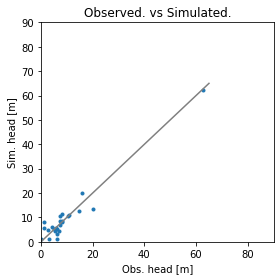

Error is - 2.8419752747795175
Params are - [6.81540489e-01 1.46989400e+01 1.66882950e+01 5.18443214e-01
 1.05107627e+00 4.94187144e-01 2.38090096e-03 6.89509182e-01
 1.66501327e-01 3.01853259e-01 1.83960188e-03 3.55591794e+00]


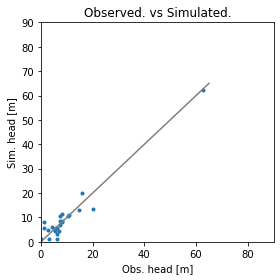

Error is - 2.8427890252928005
Params are - [6.76615203e-01 1.45866330e+01 1.66960919e+01 5.19260310e-01
 1.04556973e+00 4.95003423e-01 2.39134225e-03 6.90205109e-01
 1.63819083e-01 3.01578288e-01 1.87177124e-03 3.56097586e+00]


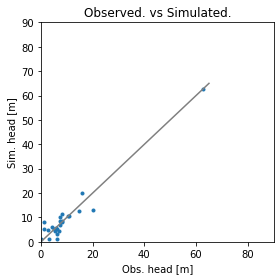

Error is - 2.8436118644138055
Params are - [6.89292613e-01 1.51103690e+01 1.64778611e+01 5.17912026e-01
 1.07157353e+00 5.01545128e-01 2.34243338e-03 6.80865145e-01
 1.71746559e-01 3.06255367e-01 1.77193130e-03 3.46240428e+00]


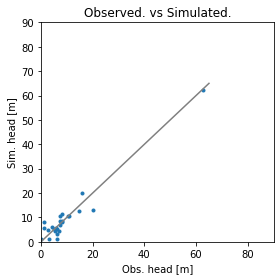

Error is - 2.8430440204589758
Params are - [6.87804249e-01 1.49674800e+01 1.65722211e+01 5.17808465e-01
 1.06441689e+00 4.97779088e-01 2.35581850e-03 6.84580194e-01
 1.70460806e-01 3.04329375e-01 1.78956292e-03 3.50365365e+00]


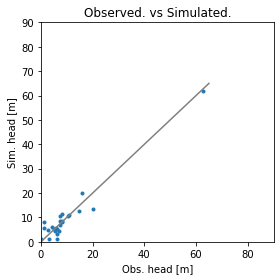

Error is - 2.8437242010915833
Params are - [6.78364804e-01 1.50221514e+01 1.69203650e+01 5.22665648e-01
 1.05484437e+00 4.77125546e-01 2.40274146e-03 6.85781127e-01
 1.67085246e-01 3.03604674e-01 1.81401346e-03 3.52266550e+00]


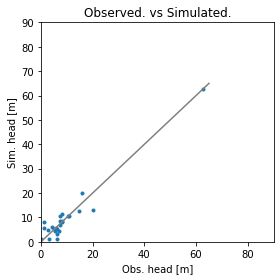

Error is - 2.8428773149634385
Params are - [6.89598992e-01 1.47622875e+01 1.65567701e+01 5.15767137e-01
 1.05897612e+00 5.01050927e-01 2.35459390e-03 6.88884890e-01
 1.70133807e-01 3.02137805e-01 1.80262658e-03 3.54921963e+00]


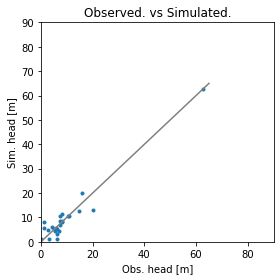

Error is - 2.842408755594155
Params are - [6.84350002e-01 1.44152395e+01 1.67200104e+01 5.14773194e-01
 1.05767091e+00 4.94600001e-01 2.36032354e-03 6.87032298e-01
 1.68208543e-01 3.02210799e-01 1.84655041e-03 3.55047240e+00]


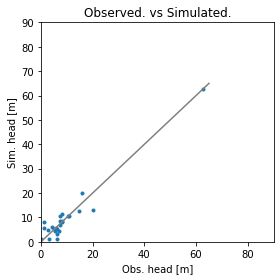

Error is - 2.843422886151402
Params are - [6.88964702e-01 1.51258423e+01 1.66345413e+01 5.15977723e-01
 1.05444900e+00 4.93740377e-01 2.34741586e-03 6.95096476e-01
 1.68685178e-01 3.00305120e-01 1.86553622e-03 3.52620036e+00]


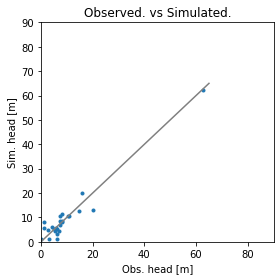

Error is - 2.8428344909394605
Params are - [6.84676891e-01 1.46458672e+01 1.66922641e+01 5.18020779e-01
 1.05897714e+00 4.93850411e-01 2.37624079e-03 6.84935838e-01
 1.69199943e-01 3.03411162e-01 1.79083496e-03 3.54875761e+00]


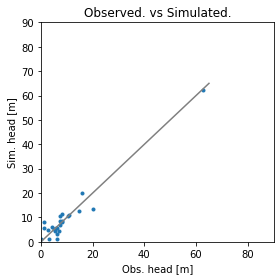

Error is - 2.842610552770066
Params are - [6.82533208e-01 1.45304695e+01 1.67791187e+01 5.22912156e-01
 1.05742196e+00 4.93488046e-01 2.39084478e-03 6.86399515e-01
 1.67165581e-01 3.00350217e-01 1.82198224e-03 3.52692123e+00]


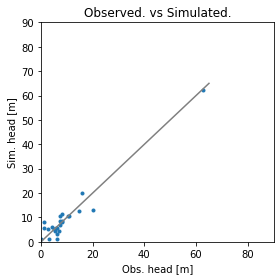

Error is - 2.842685091971472
Params are - [6.86720096e-01 1.40351331e+01 1.66280243e+01 5.13491850e-01
 1.06557874e+00 4.94387221e-01 2.37290850e-03 6.69911075e-01
 1.69824699e-01 3.04899338e-01 1.87940803e-03 3.57206493e+00]


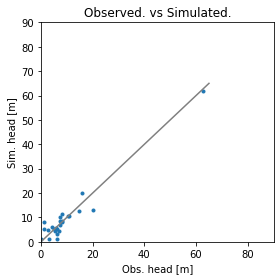

Error is - 2.8433513182599754
Params are - [6.87707315e-01 1.41235665e+01 1.68037381e+01 5.15779665e-01
 1.07440851e+00 4.92751762e-01 2.37814118e-03 6.71856817e-01
 1.69406414e-01 3.05807652e-01 1.84980242e-03 3.51258938e+00]


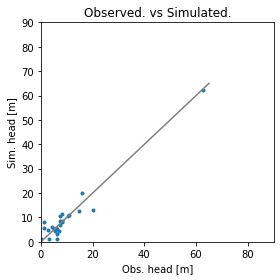

Error is - 2.8426771678406335
Params are - [6.84877407e-01 1.48609808e+01 1.66323267e+01 5.18191001e-01
 1.05253738e+00 4.94292388e-01 2.36824584e-03 6.90533308e-01
 1.68734092e-01 3.01265749e-01 1.81412679e-03 3.55677738e+00]


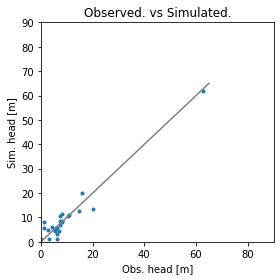

Error is - 2.843429317588148
Params are - [6.64442133e-01 1.43520499e+01 1.67029645e+01 5.17714941e-01
 1.05216521e+00 4.93213647e-01 2.40606429e-03 6.84813481e-01
 1.67029579e-01 3.01123948e-01 1.87044014e-03 3.59355490e+00]


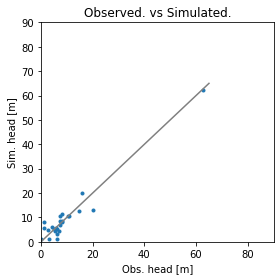

Error is - 2.842643972566942
Params are - [6.94118369e-01 1.47448832e+01 1.66780381e+01 5.17344595e-01
 1.06205693e+00 4.94055911e-01 2.35762946e-03 6.84776172e-01
 1.69691860e-01 3.03267986e-01 1.80729325e-03 3.52339136e+00]


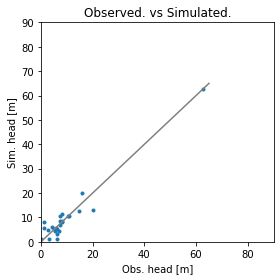

Error is - 2.842196323662053
Params are - [6.88740394e-01 1.46510948e+01 1.66378856e+01 5.13403375e-01
 1.06196192e+00 4.94034976e-01 2.36001258e-03 6.77443796e-01
 1.68136333e-01 3.02632218e-01 1.83973513e-03 3.55189180e+00]


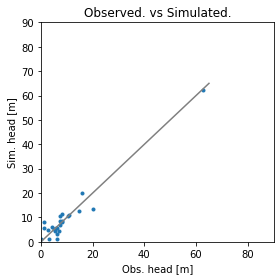

Error is - 2.84219685292251
Params are - [6.82862381e-01 1.42316810e+01 1.68033069e+01 5.15795138e-01
 1.05362184e+00 4.89224431e-01 2.38815693e-03 6.82756588e-01
 1.66791980e-01 3.00607749e-01 1.87410410e-03 3.59533369e+00]


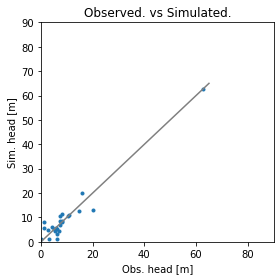

Error is - 2.8425542576642067
Params are - [6.89365902e-01 1.48936886e+01 1.67261226e+01 5.18795664e-01
 1.04822807e+00 4.95607606e-01 2.36472440e-03 6.85502147e-01
 1.68282357e-01 3.02846914e-01 1.81695162e-03 3.48777539e+00]


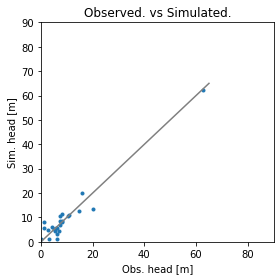

Error is - 2.842270416063229
Params are - [6.81251883e-01 1.44482320e+01 1.68689691e+01 5.18482250e-01
 1.05495857e+00 4.84735160e-01 2.39234221e-03 6.78019809e-01
 1.66499197e-01 3.02705724e-01 1.86734062e-03 3.53725869e+00]


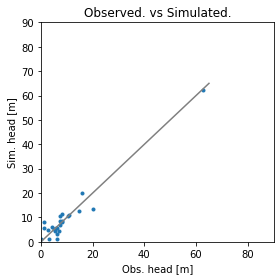

Error is - 2.8419371651810654
Params are - [6.85603150e-01 1.45317132e+01 1.67629260e+01 5.16305519e-01
 1.05428779e+00 4.90416468e-01 2.37337889e-03 6.80816189e-01
 1.66982936e-01 3.01314793e-01 1.89188319e-03 3.53580422e+00]


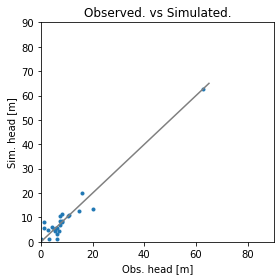

Error is - 2.8419918863560483
Params are - [6.86066280e-01 1.44746362e+01 1.67982569e+01 5.15447889e-01
 1.05194312e+00 4.88699497e-01 2.37194795e-03 6.78756365e-01
 1.65874433e-01 3.00266609e-01 1.94240730e-03 3.52932753e+00]


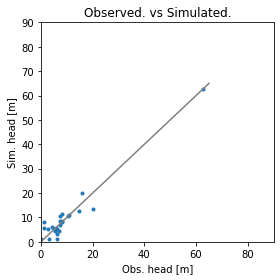

Error is - 2.8422775586336373
Params are - [6.92121756e-01 1.40780643e+01 1.69782397e+01 5.21534028e-01
 1.05627184e+00 5.01127276e-01 2.36486828e-03 6.79567289e-01
 1.67215930e-01 2.99914523e-01 1.81388032e-03 3.58667192e+00]


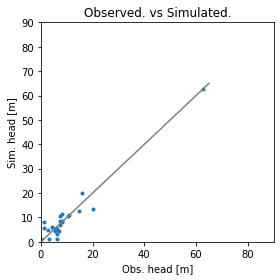

Error is - 2.8417204990521254
Params are - [6.86249230e-01 1.44832817e+01 1.64326380e+01 5.13880808e-01
 1.05474166e+00 4.93883540e-01 2.36722060e-03 6.88167425e-01
 1.67094683e-01 3.02574343e-01 1.86839150e-03 3.55045354e+00]


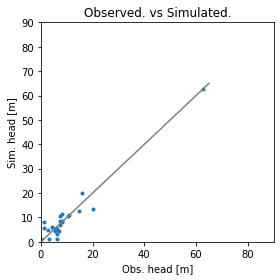

Error is - 2.84155141102582
Params are - [6.86324707e-01 1.44565534e+01 1.61233375e+01 5.10305618e-01
 1.05317730e+00 4.94420694e-01 2.36157984e-03 6.93645902e-01
 1.66353130e-01 3.03159580e-01 1.89404486e-03 3.55255033e+00]


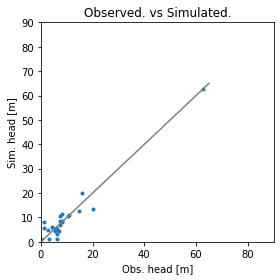

Error is - 2.843658987335429
Params are - [6.85561512e-01 1.50551236e+01 1.67717384e+01 5.20889109e-01
 1.04496639e+00 4.92311129e-01 2.37092612e-03 6.99422624e-01
 1.65269178e-01 2.98788914e-01 1.80850770e-03 3.52139613e+00]


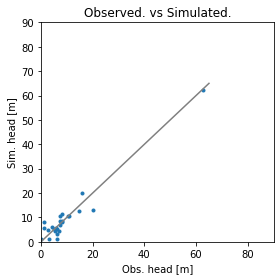

Error is - 2.8422060025733944
Params are - [6.86430450e-01 1.42901307e+01 1.66639528e+01 5.15341165e-01
 1.06042565e+00 4.93868198e-01 2.37241290e-03 6.77288963e-01
 1.68685819e-01 3.03371732e-01 1.86168295e-03 3.55939773e+00]


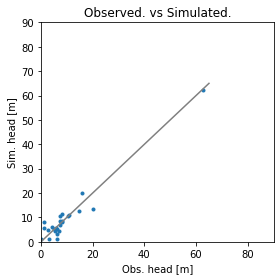

Error is - 2.8416070575128662
Params are - [6.87663041e-01 1.41341343e+01 1.67727071e+01 5.15714985e-01
 1.05932246e+00 4.92335264e-01 2.37628329e-03 6.76593001e-01
 1.66351741e-01 3.02773500e-01 1.88171497e-03 3.53712040e+00]


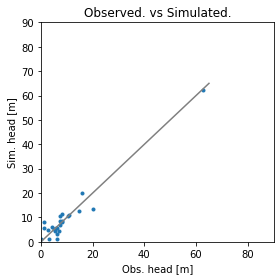

Error is - 2.842405101021296
Params are - [6.77346192e-01 1.41484403e+01 1.67427738e+01 5.16289789e-01
 1.04934716e+00 4.92284966e-01 2.39000864e-03 6.80986274e-01
 1.64837286e-01 3.00688848e-01 1.90095213e-03 3.57279460e+00]


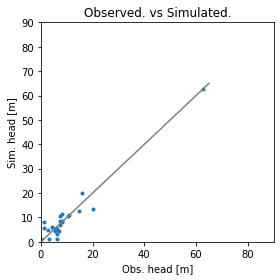

Error is - 2.842189612239348
Params are - [6.88066850e-01 1.42991825e+01 1.66356357e+01 5.09618501e-01
 1.05263634e+00 4.92652318e-01 2.35665397e-03 6.78460725e-01
 1.66975515e-01 3.03663056e-01 1.89942479e-03 3.57691029e+00]


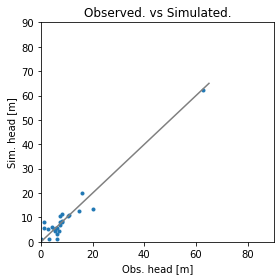

Error is - 2.841944256360636
Params are - [6.81017647e-01 1.38368790e+01 1.66735506e+01 5.12205465e-01
 1.06256494e+00 4.90040210e-01 2.38142927e-03 6.78184522e-01
 1.65640932e-01 3.01302383e-01 1.91820094e-03 3.63091195e+00]


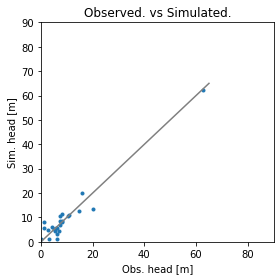

Error is - 2.8414704406904323
Params are - [6.85478155e-01 1.42189348e+01 1.66719196e+01 5.15799981e-01
 1.05393777e+00 4.90287850e-01 2.38934775e-03 6.75179742e-01
 1.65286812e-01 3.01787096e-01 1.90054391e-03 3.58162153e+00]


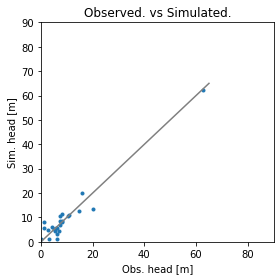

Error is - 2.842324486142584
Params are - [6.86042231e-01 1.41207824e+01 1.66478742e+01 5.16313374e-01
 1.05207120e+00 4.88131774e-01 2.40385985e-03 6.69253464e-01
 1.63825946e-01 3.01575244e-01 1.92754066e-03 3.59719610e+00]


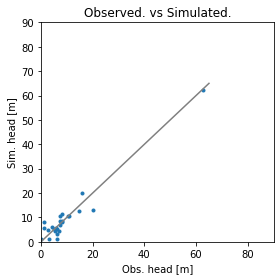

Error is - 2.8421318584643447
Params are - [6.93837292e-01 1.44974830e+01 1.66373471e+01 5.14201750e-01
 1.06302662e+00 4.92270032e-01 2.35955250e-03 6.80258010e-01
 1.68732989e-01 3.03492087e-01 1.84607414e-03 3.56077048e+00]


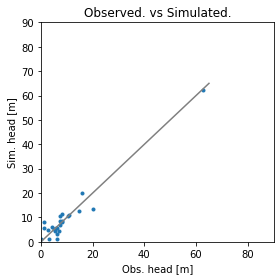

Error is - 2.84185839675227
Params are - [6.79347650e-01 1.46377622e+01 1.63450658e+01 5.07735465e-01
 1.05722774e+00 4.81951515e-01 2.38380691e-03 6.81792116e-01
 1.66607189e-01 3.04862673e-01 1.93851160e-03 3.54257626e+00]


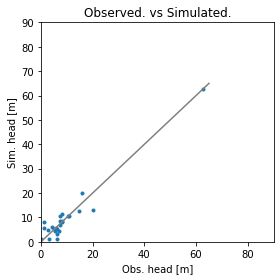

Error is - 2.8418895299491895
Params are - [6.89900151e-01 1.42991828e+01 1.63670192e+01 5.08996113e-01
 1.05891920e+00 4.97879690e-01 2.35491042e-03 6.83968314e-01
 1.67341920e-01 3.02430964e-01 1.89691312e-03 3.59287575e+00]


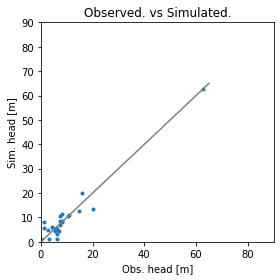

Error is - 2.841500863324495
Params are - [6.85299868e-01 1.44587928e+01 1.65225465e+01 5.11079689e-01
 1.05320105e+00 4.89415234e-01 2.37192265e-03 6.85812385e-01
 1.64931315e-01 3.01608161e-01 1.90844249e-03 3.57631638e+00]


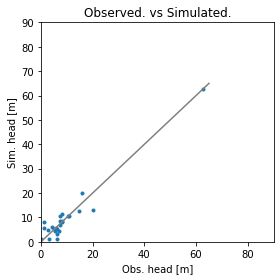

Error is - 2.8417175002618293
Params are - [6.89274185e-01 1.45550944e+01 1.63363991e+01 5.09839808e-01
 1.05993473e+00 4.94090801e-01 2.35347291e-03 6.80854059e-01
 1.66515043e-01 3.04538879e-01 1.90174440e-03 3.53721086e+00]


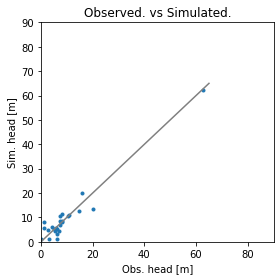

Error is - 2.8415175859782655
Params are - [6.83485136e-01 1.41196806e+01 1.64515726e+01 5.11637643e-01
 1.05125678e+00 4.89289561e-01 2.38052731e-03 6.86735228e-01
 1.64900475e-01 3.02832187e-01 1.94644825e-03 3.57820594e+00]


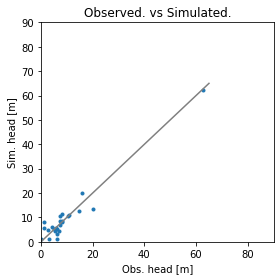

Error is - 2.8415994537221776
Params are - [6.83395062e-01 1.44416759e+01 1.64231453e+01 5.15759041e-01
 1.06035243e+00 4.90111759e-01 2.38786481e-03 6.87097384e-01
 1.65715453e-01 3.01662871e-01 1.89459584e-03 3.55340338e+00]


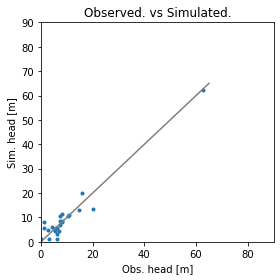

Error is - 2.8423307603037835
Params are - [6.75884248e-01 1.42340742e+01 1.63857336e+01 5.11435340e-01
 1.04951646e+00 4.90134333e-01 2.38968500e-03 6.86439994e-01
 1.63455056e-01 3.01528971e-01 1.95603343e-03 3.56831534e+00]


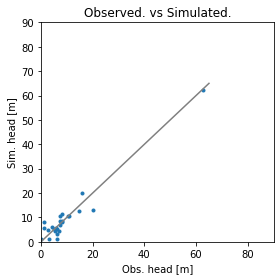

Error is - 2.8417302848671975
Params are - [6.89349031e-01 1.44316308e+01 1.65744437e+01 5.13510148e-01
 1.05964908e+00 4.91736107e-01 2.36708563e-03 6.81803506e-01
 1.67413506e-01 3.03001308e-01 1.87356397e-03 3.56265670e+00]


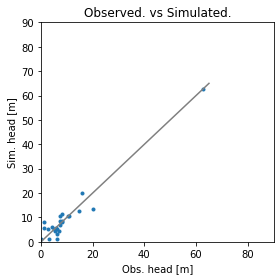

Error is - 2.8414485379436236
Params are - [6.89482475e-01 1.39880656e+01 1.63158105e+01 5.06371698e-01
 1.06289561e+00 4.87808714e-01 2.36603398e-03 6.75904543e-01
 1.65838749e-01 3.03359141e-01 1.96816604e-03 3.57429101e+00]


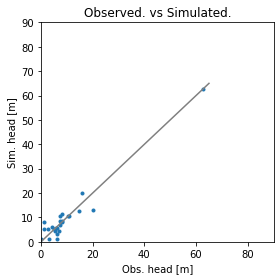

Error is - 2.841679927814934
Params are - [6.93453469e-01 1.36326284e+01 1.61295682e+01 5.00335940e-01
 1.06880528e+00 4.84619499e-01 2.35860049e-03 6.69102223e-01
 1.65507460e-01 3.04112082e-01 2.03244811e-03 3.58347755e+00]


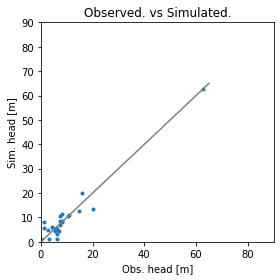

Error is - 2.841636437887385
Params are - [6.91416122e-01 1.48753244e+01 1.62709315e+01 5.11637153e-01
 1.05146205e+00 4.91583733e-01 2.36293979e-03 6.86849206e-01
 1.66732113e-01 3.04252809e-01 1.89789450e-03 3.48986018e+00]


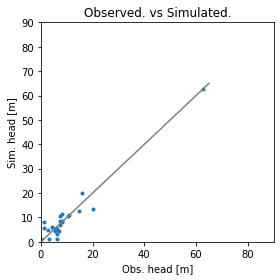

Error is - 2.840952156905877
Params are - [6.87799447e-01 1.42377588e+01 1.60995571e+01 5.06759038e-01
 1.05926824e+00 4.91402019e-01 2.36925032e-03 6.85223042e-01
 1.65348305e-01 3.04730068e-01 1.92521414e-03 3.57731056e+00]


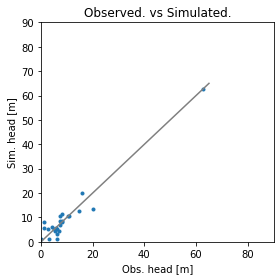

Error is - 2.840601258787899
Params are - [6.88897595e-01 1.40907816e+01 1.57678726e+01 5.01985797e-01
 1.06175847e+00 4.91894794e-01 2.36718603e-03 6.87426468e-01
 1.64530989e-01 3.06437706e-01 1.94187962e-03 3.59806373e+00]


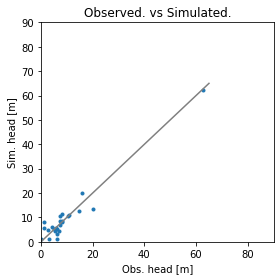

Error is - 2.841183115838724
Params are - [6.83335354e-01 1.44355557e+01 1.63956061e+01 5.12900058e-01
 1.05511004e+00 4.82941314e-01 2.38976473e-03 6.82647277e-01
 1.64520832e-01 3.04281688e-01 1.92767862e-03 3.52110370e+00]


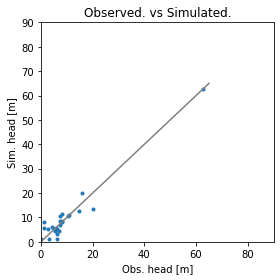

Error is - 2.841382531304835
Params are - [6.94552471e-01 1.40632752e+01 1.64259829e+01 5.15021472e-01
 1.05644856e+00 4.99034456e-01 2.36186121e-03 6.84966001e-01
 1.64907837e-01 3.01753148e-01 1.88427464e-03 3.56782443e+00]


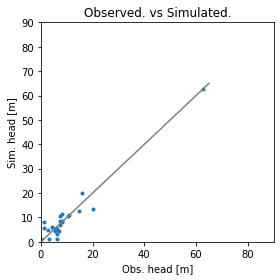

Error is - 2.841109783439288
Params are - [6.85418331e-01 1.42080140e+01 1.61718615e+01 5.09498676e-01
 1.05349379e+00 4.90466255e-01 2.37771176e-03 6.85481693e-01
 1.63683909e-01 3.03406486e-01 1.95100739e-03 3.54860528e+00]


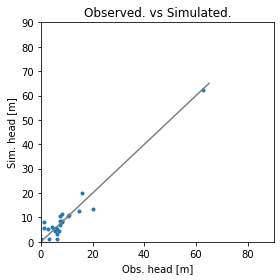

Error is - 2.841893309873474
Params are - [6.84850535e-01 1.40267036e+01 1.63824832e+01 5.13112161e-01
 1.05213466e+00 4.87507470e-01 2.39536428e-03 6.87202412e-01
 1.64110516e-01 3.01680183e-01 1.93103745e-03 3.57595019e+00]


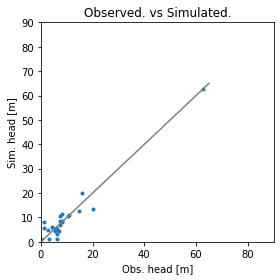

Error is - 2.8413451930519966
Params are - [6.88168272e-01 1.44229967e+01 1.63479201e+01 5.10657896e-01
 1.05798471e+00 4.92444968e-01 2.36394575e-03 6.82441148e-01
 1.65913911e-01 3.03824205e-01 1.90906767e-03 3.54689569e+00]


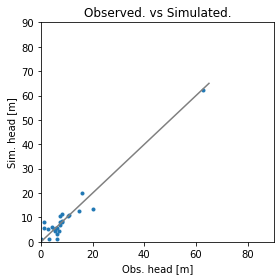

Error is - 2.8414899420862314
Params are - [6.82167290e-01 1.36310857e+01 1.64607822e+01 5.11151606e-01
 1.06169445e+00 4.90158078e-01 2.38606506e-03 6.80472589e-01
 1.63757080e-01 3.01894819e-01 1.93674955e-03 3.63280679e+00]


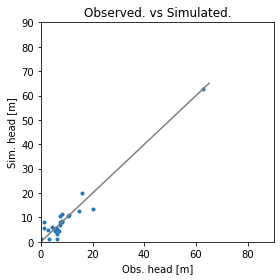

Error is - 2.8409705605653404
Params are - [6.85004412e-01 1.42884344e+01 1.59070191e+01 5.06313211e-01
 1.05422937e+00 4.89043682e-01 2.37435186e-03 6.91375393e-01
 1.63705008e-01 3.03227681e-01 1.96210151e-03 3.60149430e+00]


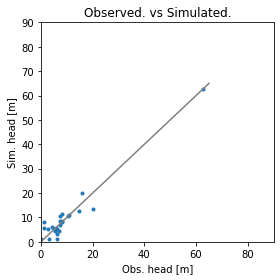

Error is - 2.8416619612991805
Params are - [6.89540616e-01 1.39553525e+01 1.61705599e+01 5.04694850e-01
 1.05217888e+00 4.91089174e-01 2.36051818e-03 6.81584011e-01
 1.64006221e-01 3.04599112e-01 1.96047159e-03 3.59322647e+00]


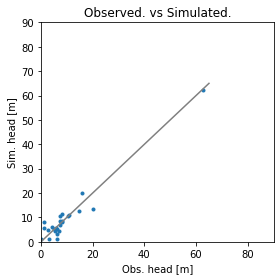

Error is - 2.8412119653636467
Params are - [6.84931450e-01 1.43200950e+01 1.63599990e+01 5.12992993e-01
 1.05830905e+00 4.90356113e-01 2.38102815e-03 6.85719041e-01
 1.65288145e-01 3.02396931e-01 1.91106477e-03 3.56335915e+00]


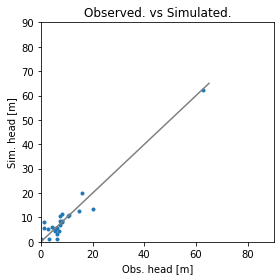

Error is - 2.8411402849171252
Params are - [6.86378761e-01 1.39177320e+01 1.65098113e+01 5.10596169e-01
 1.06020931e+00 4.86102809e-01 2.39004454e-03 6.73714349e-01
 1.63191047e-01 3.02975295e-01 1.96385921e-03 3.59588099e+00]


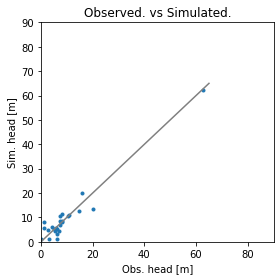

Error is - 2.8407841154409987
Params are - [6.89700603e-01 1.42209466e+01 1.61912827e+01 5.09090565e-01
 1.06362191e+00 4.90702817e-01 2.37268327e-03 6.78454876e-01
 1.64358797e-01 3.03326539e-01 1.91435765e-03 3.57317123e+00]


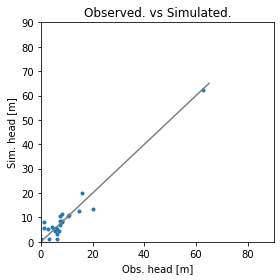

Error is - 2.840806124540258
Params are - [6.88619327e-01 1.38421934e+01 1.60650981e+01 5.09316998e-01
 1.06341446e+00 4.90791741e-01 2.38141470e-03 6.78151468e-01
 1.64232538e-01 3.04836962e-01 1.95334927e-03 3.57453660e+00]


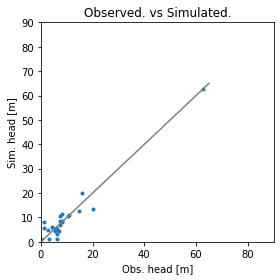

Error is - 2.84098402794648
Params are - [6.92827245e-01 1.47050852e+01 1.60609150e+01 5.08939313e-01
 1.05520773e+00 4.90154508e-01 2.36649723e-03 6.83104410e-01
 1.65486016e-01 3.05040660e-01 1.92780883e-03 3.50833449e+00]


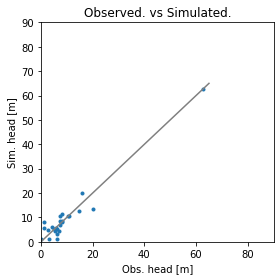

Error is - 2.8408333466231777
Params are - [6.90741228e-01 1.41982611e+01 1.57479436e+01 5.03147494e-01
 1.06317606e+00 4.90002513e-01 2.35940612e-03 6.89718036e-01
 1.63989485e-01 3.05690645e-01 1.96855863e-03 3.54730524e+00]


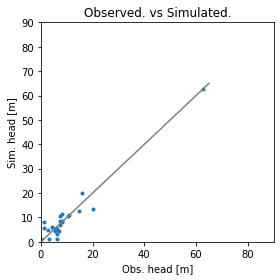

Error is - 2.8406435068629663
Params are - [6.86946700e-01 1.44641628e+01 1.60094082e+01 5.12038409e-01
 1.05426497e+00 4.92847281e-01 2.38161525e-03 6.91295484e-01
 1.63129337e-01 3.04507184e-01 1.90100193e-03 3.55013813e+00]


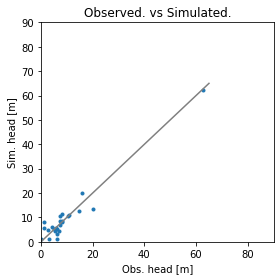

Error is - 2.840851137426984
Params are - [6.80609075e-01 1.44557679e+01 1.58298066e+01 5.02891458e-01
 1.06034809e+00 4.80590344e-01 2.38908035e-03 6.83288939e-01
 1.63763832e-01 3.06572182e-01 1.98768121e-03 3.55365699e+00]


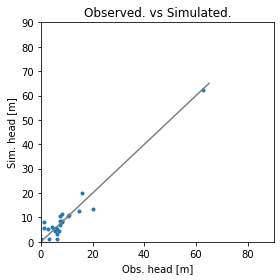

Error is - 2.840515717668738
Params are - [6.85733408e-01 1.41015082e+01 1.58215172e+01 5.05960627e-01
 1.05920583e+00 4.85204060e-01 2.39118491e-03 6.85955091e-01
 1.62399411e-01 3.04959121e-01 1.97599044e-03 3.57571261e+00]


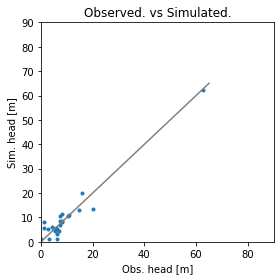

Error is - 2.8412231233858405
Params are - [6.84515976e-01 1.39407640e+01 1.55583157e+01 5.03611993e-01
 1.05981639e+00 4.81583607e-01 2.40480449e-03 6.87712063e-01
 1.60642161e-01 3.05526580e-01 2.00945183e-03 3.59012107e+00]


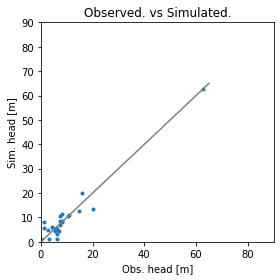

Error is - 2.8402194059464536
Params are - [6.89103889e-01 1.41679788e+01 1.57196914e+01 5.02453469e-01
 1.05903096e+00 4.86434241e-01 2.37579531e-03 6.82716540e-01
 1.62543721e-01 3.06813427e-01 1.98481428e-03 3.56130806e+00]


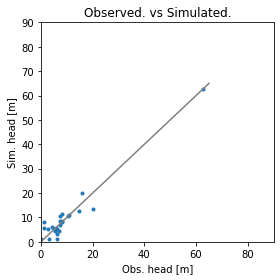

Error is - 2.8399646922910486
Params are - [6.91190108e-01 1.40919206e+01 1.53995376e+01 4.97183707e-01
 1.05939191e+00 4.84473304e-01 2.37317888e-03 6.81215290e-01
 1.61171509e-01 3.09021675e-01 2.02168903e-03 3.56028252e+00]


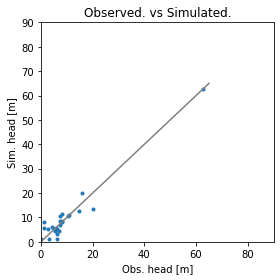

Error is - 2.840407400271152
Params are - [6.92009112e-01 1.39952456e+01 1.55180728e+01 4.99927013e-01
 1.06294361e+00 4.94104371e-01 2.36429443e-03 6.85549640e-01
 1.62752814e-01 3.05718668e-01 1.98386884e-03 3.61009332e+00]


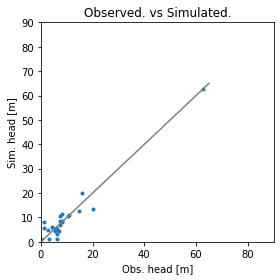

Error is - 2.8405070104481345
Params are - [6.89904096e-01 1.45259883e+01 1.52385779e+01 5.00452709e-01
 1.05830006e+00 4.92276469e-01 2.35972293e-03 6.96455116e-01
 1.64009561e-01 3.07482290e-01 1.95102318e-03 3.53768475e+00]


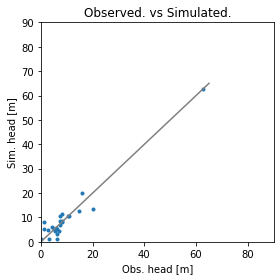

Error is - 2.840128097592921
Params are - [6.91612154e-01 1.42887020e+01 1.54209804e+01 5.00042541e-01
 1.06581662e+00 4.88214726e-01 2.36905757e-03 6.86516675e-01
 1.63570974e-01 3.07730399e-01 1.96387763e-03 3.58314037e+00]


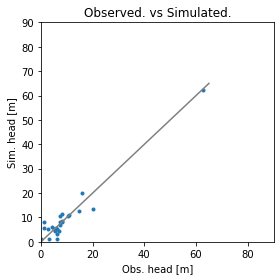

Error is - 2.84026780607008
Params are - [6.84000725e-01 1.37222336e+01 1.54252711e+01 4.99119108e-01
 1.06587083e+00 4.88203176e-01 2.38069882e-03 6.89462669e-01
 1.61449693e-01 3.06544515e-01 1.99308766e-03 3.63587881e+00]


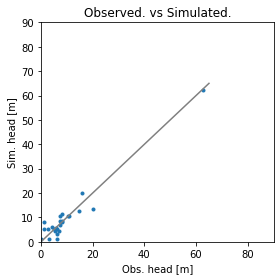

Error is - 2.840049539671957
Params are - [6.91656277e-01 1.40445176e+01 1.54988757e+01 5.00546193e-01
 1.06878943e+00 4.89173917e-01 2.37390202e-03 6.80872899e-01
 1.62854815e-01 3.08910300e-01 1.96395934e-03 3.54844975e+00]


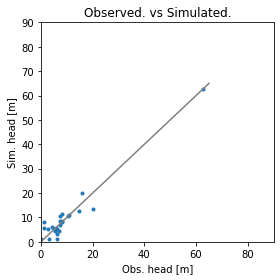

Error is - 2.840628509315241
Params are - [6.97892814e-01 1.38086423e+01 1.55209330e+01 5.03577068e-01
 1.06407761e+00 4.99057851e-01 2.35664380e-03 6.88556679e-01
 1.62644489e-01 3.05955485e-01 1.93442599e-03 3.59541919e+00]


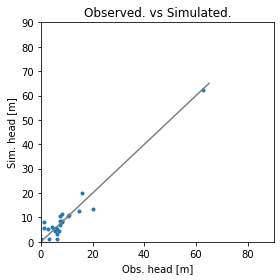

Error is - 2.8399294184283232
Params are - [6.88952592e-01 1.40012127e+01 1.55649610e+01 5.03392629e-01
 1.06139989e+00 4.91154906e-01 2.38585765e-03 6.81934023e-01
 1.62194670e-01 3.06881162e-01 1.94785980e-03 3.60978993e+00]


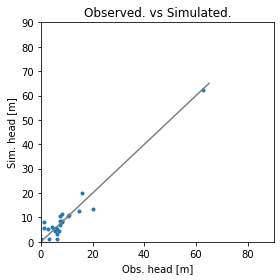

Error is - 2.8401715226418025
Params are - [6.88058273e-01 1.39026884e+01 1.54734697e+01 5.03515196e-01
 1.06051180e+00 4.91731102e-01 2.39908341e-03 6.78042017e-01
 1.61297262e-01 3.07476421e-01 1.93751039e-03 3.64103227e+00]


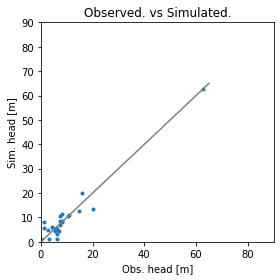

Error is - 2.8400965644284213
Params are - [6.91130037e-01 1.43837836e+01 1.51644503e+01 4.96235730e-01
 1.06082573e+00 4.90426204e-01 2.36458956e-03 6.94131017e-01
 1.61611972e-01 3.08075546e-01 1.96215424e-03 3.58843413e+00]


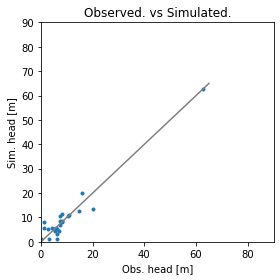

Error is - 2.8396671648112286
Params are - [6.90287000e-01 1.40321699e+01 1.48671269e+01 4.94319691e-01
 1.06015224e+00 4.90469026e-01 2.37197204e-03 6.96440299e-01
 1.61027909e-01 3.10377469e-01 2.00911196e-03 3.59234331e+00]


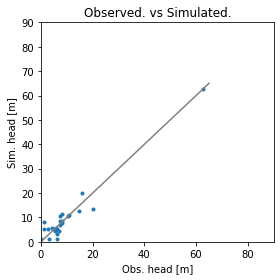

Error is - 2.8397991942758516
Params are - [6.90580199e-01 1.39377816e+01 1.42050491e+01 4.86934254e-01
 1.05841741e+00 4.90352130e-01 2.37161642e-03 7.05433011e-01
 1.59362464e-01 3.13902934e-01 2.05648912e-03 3.60192934e+00]


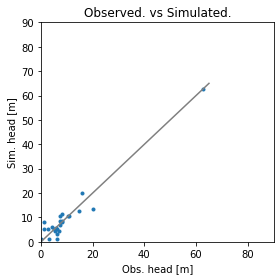

Error is - 2.8401477422123644
Params are - [6.93597620e-01 1.37169548e+01 1.48586212e+01 4.88418727e-01
 1.07049040e+00 4.87928187e-01 2.36143286e-03 6.84457161e-01
 1.61907131e-01 3.10175205e-01 2.04048602e-03 3.62241060e+00]


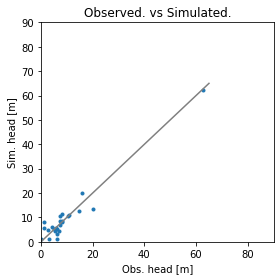

Error is - 2.8401117983655793
Params are - [6.81935640e-01 1.43571941e+01 1.52367111e+01 4.94353677e-01
 1.06174656e+00 4.79862672e-01 2.38720248e-03 6.86512712e-01
 1.62269086e-01 3.09430191e-01 2.02473863e-03 3.58162812e+00]


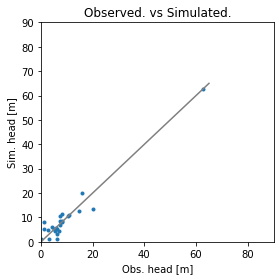

Error is - 2.8394953942032415
Params are - [6.89770532e-01 1.41194569e+01 1.49012446e+01 4.94672928e-01
 1.06406372e+00 4.85020375e-01 2.37999632e-03 6.87490631e-01
 1.60005602e-01 3.09446718e-01 2.03109485e-03 3.57624430e+00]


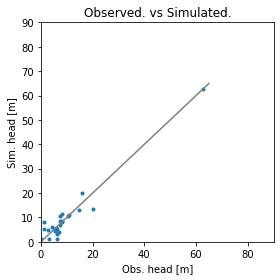

Error is - 2.8397504181265565
Params are - [6.90207001e-01 1.41337946e+01 1.44679305e+01 4.91016493e-01
 1.06521634e+00 4.81583166e-01 2.38640146e-03 6.87522712e-01
 1.57742908e-01 3.10951224e-01 2.07570246e-03 3.56533458e+00]


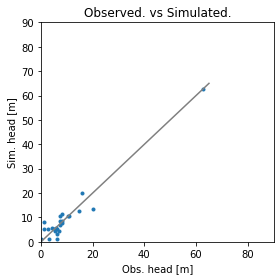

Error is - 2.840166697311482
Params are - [6.93607574e-01 1.41117217e+01 1.46942212e+01 4.88816815e-01
 1.06742600e+00 4.91680495e-01 2.35413268e-03 6.89217931e-01
 1.61738212e-01 3.11673235e-01 2.00616809e-03 3.59868403e+00]


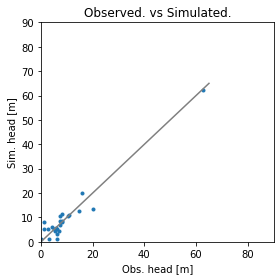

Error is - 2.8399699724864504
Params are - [6.90054132e-01 1.36181972e+01 1.51864344e+01 4.92385417e-01
 1.06985276e+00 4.84508757e-01 2.38466295e-03 6.77511709e-01
 1.59749504e-01 3.09848557e-01 2.04032617e-03 3.64687845e+00]


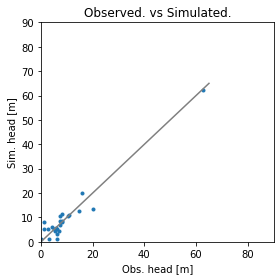

Error is - 2.839535179342848
Params are - [6.87623287e-01 1.40860985e+01 1.48516665e+01 4.91654181e-01
 1.06636074e+00 4.81081587e-01 2.38348621e-03 6.87077530e-01
 1.60505699e-01 3.12300494e-01 2.01689007e-03 3.58060073e+00]


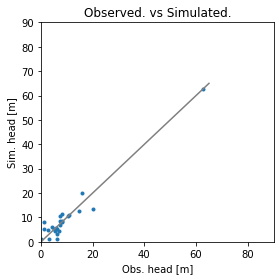

Error is - 2.8395536125516707
Params are - [6.96235434e-01 1.44197547e+01 1.48488674e+01 4.91217931e-01
 1.06351517e+00 4.85795850e-01 2.36754638e-03 6.82766977e-01
 1.61651487e-01 3.12433977e-01 2.01163832e-03 3.54560223e+00]


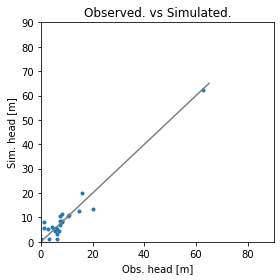

Error is - 2.8402723714423885
Params are - [6.87066561e-01 1.40816054e+01 1.56056916e+01 5.01920411e-01
 1.06130819e+00 4.81337757e-01 2.39634814e-03 6.81936557e-01
 1.61348515e-01 3.07432047e-01 1.99946959e-03 3.57395003e+00]


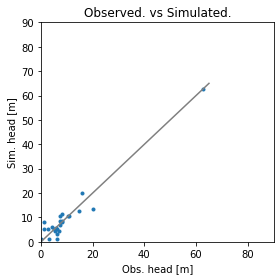

Error is - 2.839830277642321
Params are - [6.91972321e-01 1.41041926e+01 1.49220888e+01 4.92092714e-01
 1.06589655e+00 4.89094811e-01 2.36468654e-03 6.87397587e-01
 1.61640787e-01 3.10612938e-01 2.00449346e-03 3.59250053e+00]


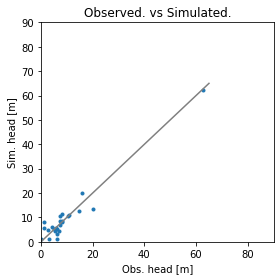

Error is - 2.840037199686527
Params are - [6.86805632e-01 1.45409119e+01 1.54518696e+01 5.02930830e-01
 1.05747815e+00 4.85284503e-01 2.38959024e-03 6.87187398e-01
 1.61135205e-01 3.09003032e-01 1.95915289e-03 3.54523845e+00]


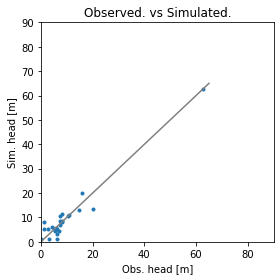

Error is - 2.8398548709007696
Params are - [6.87990012e-01 1.40111997e+01 1.48946585e+01 4.91788397e-01
 1.06076220e+00 4.84509593e-01 2.38538764e-03 6.85239670e-01
 1.59065400e-01 3.11659944e-01 2.03497383e-03 3.57819170e+00]


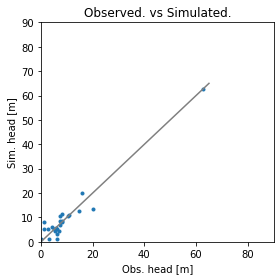

Error is - 2.8397087856170526
Params are - [6.98675587e-01 1.38850419e+01 1.50219191e+01 4.97049714e-01
 1.06466819e+00 4.93636133e-01 2.36694026e-03 6.85031459e-01
 1.59833341e-01 3.10331777e-01 1.97581870e-03 3.57913122e+00]


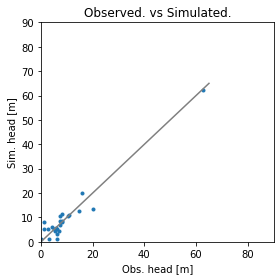

Error is - 2.8396996790407525
Params are - [6.90738782e-01 1.37753288e+01 1.50704247e+01 4.95303325e-01
 1.06622943e+00 4.83607590e-01 2.38994496e-03 6.75896561e-01
 1.60194015e-01 3.12062462e-01 2.04068049e-03 3.57077473e+00]


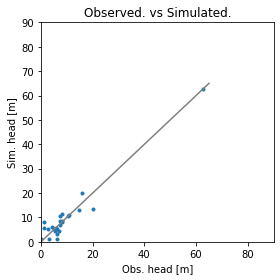

Error is - 2.840208113567186
Params are - [6.90059627e-01 1.40697300e+01 1.46645909e+01 4.90119051e-01
 1.05783906e+00 4.83932155e-01 2.38330633e-03 6.88325290e-01
 1.58507706e-01 3.11753068e-01 2.05166226e-03 3.61447993e+00]


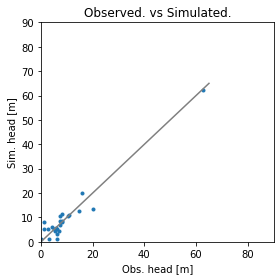

Error is - 2.8397694664336037
Params are - [6.91257114e-01 1.40508207e+01 1.52903045e+01 4.97939408e-01
 1.06605184e+00 4.87863477e-01 2.37625309e-03 6.82735997e-01
 1.61768038e-01 3.09620992e-01 1.98588507e-03 3.56495729e+00]


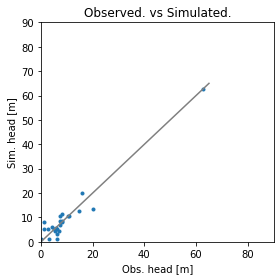

Error is - 2.84004693230076
Params are - [6.95652185e-01 1.34916538e+01 1.46846694e+01 4.86902511e-01
 1.07057929e+00 4.88251399e-01 2.36539525e-03 6.81268891e-01
 1.60332788e-01 3.11763329e-01 2.06092406e-03 3.62097770e+00]


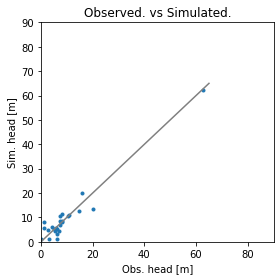

Error is - 2.8395748933984533
Params are - [6.89017270e-01 1.42785974e+01 1.52600695e+01 4.98923750e-01
 1.06075344e+00 4.86026227e-01 2.38354149e-03 6.85707771e-01
 1.60934601e-01 3.09693106e-01 1.98459569e-03 3.56417327e+00]


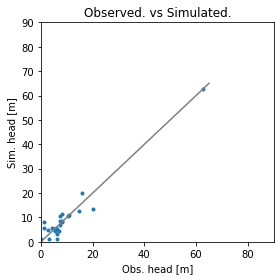

Error is - 2.8396709555339243
Params are - [6.92230874e-01 1.45244352e+01 1.49623771e+01 4.98537645e-01
 1.05668812e+00 4.89280056e-01 2.37013563e-03 6.92310590e-01
 1.61916006e-01 3.10891895e-01 1.97046237e-03 3.50555351e+00]


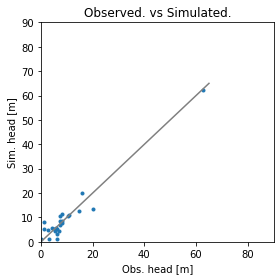

Error is - 2.839253137675871
Params are - [6.91268359e-01 1.41227975e+01 1.46764138e+01 4.93965012e-01
 1.06669834e+00 4.90116634e-01 2.38111249e-03 6.90456226e-01
 1.60618083e-01 3.12030481e-01 1.98056174e-03 3.58302794e+00]


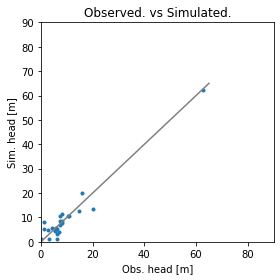

Error is - 2.8391769943532417
Params are - [6.91307484e-01 1.41382360e+01 1.43148519e+01 4.92355664e-01
 1.07035156e+00 4.92938299e-01 2.38507929e-03 6.95076695e-01
 1.60341370e-01 3.13534885e-01 1.95999809e-03 3.59440065e+00]


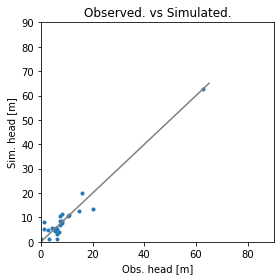

Error is - 2.839431025182101
Params are - [6.93898358e-01 1.42363427e+01 1.43026389e+01 4.85916596e-01
 1.06618231e+00 4.83732265e-01 2.36830400e-03 6.91927938e-01
 1.59286039e-01 3.15279947e-01 2.05641401e-03 3.53095565e+00]


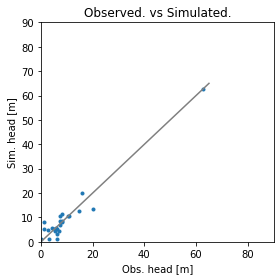

Error is - 2.8396117450523137
Params are - [6.95845663e-01 1.42638795e+01 1.48742715e+01 4.96542194e-01
 1.06772336e+00 4.90248023e-01 2.36592673e-03 6.89737003e-01
 1.62452082e-01 3.11104499e-01 1.97287335e-03 3.55468120e+00]


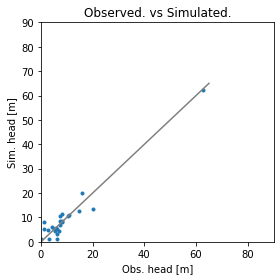

Error is - 2.839194939629476
Params are - [6.92508910e-01 1.41975010e+01 1.48388716e+01 4.96979458e-01
 1.06289347e+00 4.85855007e-01 2.38683452e-03 6.87968988e-01
 1.60011911e-01 3.12233432e-01 1.99808370e-03 3.53406915e+00]


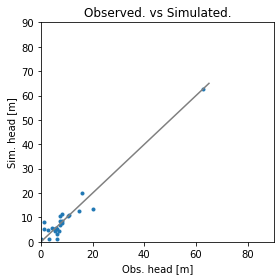

Error is - 2.839086592966523
Params are - [6.93432750e-01 1.42753197e+01 1.43954172e+01 4.90972772e-01
 1.06221179e+00 4.86751596e-01 2.37703154e-03 6.93502743e-01
 1.59591972e-01 3.13660785e-01 2.01872520e-03 3.55646436e+00]


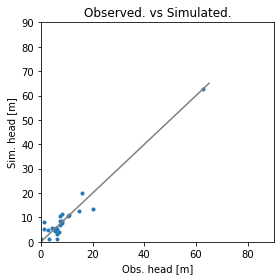

Error is - 2.8391672360409195
Params are - [6.94520568e-01 1.43875692e+01 1.39479735e+01 4.87489454e-01
 1.06029176e+00 4.86195656e-01 2.37742077e-03 6.98886117e-01
 1.58503939e-01 3.15680682e-01 2.03514526e-03 3.55221790e+00]


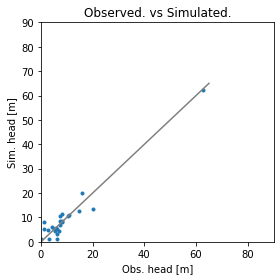

Error is - 2.83959006629632
Params are - [6.85140470e-01 1.45061448e+01 1.45593855e+01 4.90849641e-01
 1.06318604e+00 4.79831517e-01 2.38802626e-03 6.92619162e-01
 1.61486441e-01 3.13504834e-01 2.03594265e-03 3.53851263e+00]


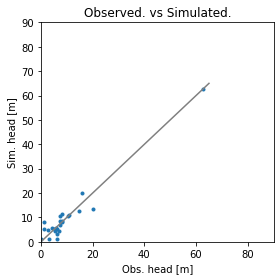

Error is - 2.8396871736176625
Params are - [6.92144223e-01 1.47376606e+01 1.44257067e+01 4.91853750e-01
 1.06111756e+00 4.89230715e-01 2.36470177e-03 7.04541160e-01
 1.61341171e-01 3.12014545e-01 1.97029122e-03 3.54149210e+00]


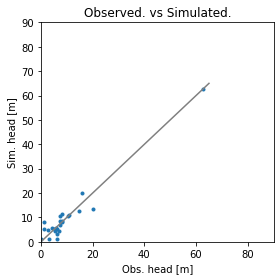

Error is - 2.8394189667581813
Params are - [6.91792863e-01 1.44970776e+01 1.45868862e+01 4.92716144e-01
 1.06239553e+00 4.87824934e-01 2.37101257e-03 6.97380010e-01
 1.61054382e-01 3.12026524e-01 1.98788854e-03 3.54881276e+00]


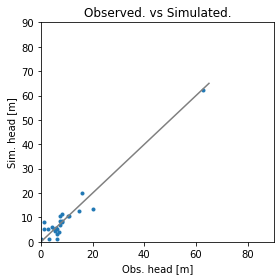

Error is - 2.8394234130832716
Params are - [6.90579129e-01 1.39839946e+01 1.44711725e+01 4.87649179e-01
 1.07161011e+00 4.83315728e-01 2.38465727e-03 6.88972034e-01
 1.59475576e-01 3.13374217e-01 2.04341370e-03 3.61392319e+00]


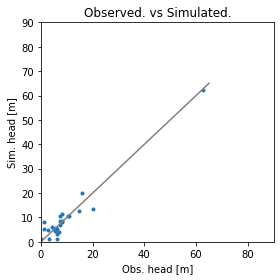

Error is - 2.839321316433107
Params are - [6.92571692e-01 1.44682307e+01 1.45004303e+01 4.90755382e-01
 1.07005563e+00 4.80934542e-01 2.38493506e-03 6.83597614e-01
 1.60104952e-01 3.14388101e-01 2.01048106e-03 3.53073005e+00]


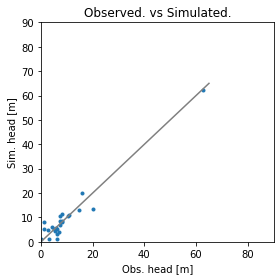

Error is - 2.839529573993417
Params are - [6.86467368e-01 1.42705796e+01 1.44309789e+01 4.87568411e-01
 1.06287323e+00 4.79603298e-01 2.39414843e-03 6.89277679e-01
 1.58289590e-01 3.14208337e-01 2.05298763e-03 3.56440030e+00]


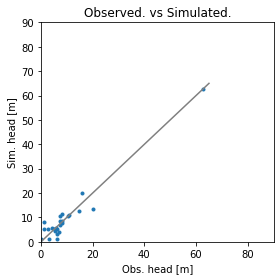

Error is - 2.8393363724040213
Params are - [6.97393709e-01 1.39890534e+01 1.47244637e+01 4.92714091e-01
 1.06735841e+00 4.89981768e-01 2.37306925e-03 6.85838607e-01
 1.58722422e-01 3.11925253e-01 1.99275915e-03 3.58488348e+00]


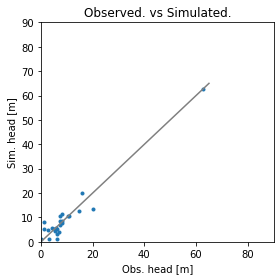

Error is - 2.8390714419039864
Params are - [6.94912982e-01 1.41683435e+01 1.39345121e+01 4.83605039e-01
 1.07089184e+00 4.84446315e-01 2.37580865e-03 6.92771803e-01
 1.58905566e-01 3.16109005e-01 2.04546670e-03 3.56267454e+00]


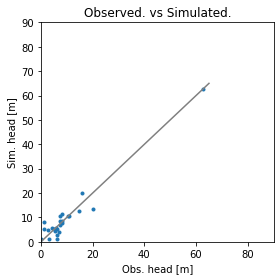

Error is - 2.8391633209042246
Params are - [6.97860838e-01 1.41132166e+01 1.32717333e+01 4.75945684e-01
 1.07596104e+00 4.83656359e-01 2.37194223e-03 6.96303819e-01
 1.57891048e-01 3.19316955e-01 2.07590221e-03 3.56192518e+00]


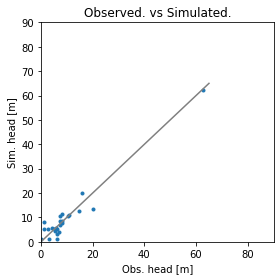

Error is - 2.839239917715522
Params are - [6.87474410e-01 1.39852844e+01 1.41933217e+01 4.90042043e-01
 1.06935955e+00 4.84451769e-01 2.39318080e-03 6.97380068e-01
 1.57731026e-01 3.13980640e-01 2.02406213e-03 3.58409097e+00]


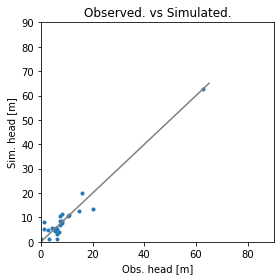

Error is - 2.838914755090016
Params are - [6.96061745e-01 1.43021382e+01 1.40807985e+01 4.89337103e-01
 1.06701378e+00 4.89727729e-01 2.37885674e-03 6.94786606e-01
 1.58414369e-01 3.14394147e-01 2.02000573e-03 3.54967417e+00]


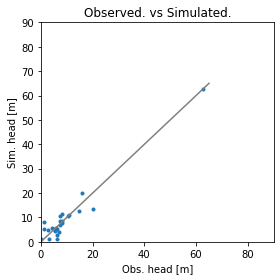

Error is - 2.8388489892147923
Params are - [7.00280974e-01 1.44101580e+01 1.36953645e+01 4.88178564e-01
 1.06734029e+00 4.94050801e-01 2.37654200e-03 6.98641143e-01
 1.57368705e-01 3.15440973e-01 2.02156355e-03 3.53421089e+00]


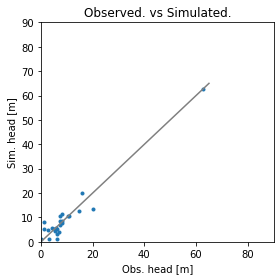

Error is - 2.839277724866976
Params are - [6.99519932e-01 1.41409202e+01 1.43788836e+01 4.93524566e-01
 1.07124581e+00 4.93613935e-01 2.36526012e-03 6.94147033e-01
 1.60476997e-01 3.12691743e-01 1.97867082e-03 3.56084304e+00]


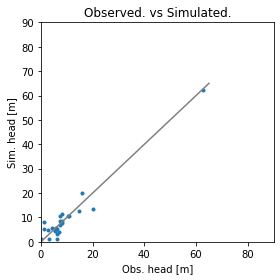

Error is - 2.8389385340755253
Params are - [6.97841667e-01 1.42956201e+01 1.38215578e+01 4.86228655e-01
 1.07125233e+00 4.89629118e-01 2.37695619e-03 6.97043482e-01
 1.58839551e-01 3.17994200e-01 1.99182626e-03 3.54643216e+00]


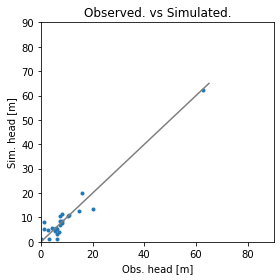

Error is - 2.839040488327236
Params are - [6.94371059e-01 1.41886138e+01 1.43399833e+01 4.95036997e-01
 1.06997874e+00 4.91900037e-01 2.39009055e-03 6.93458766e-01
 1.59484699e-01 3.12613346e-01 1.95574247e-03 3.59430022e+00]


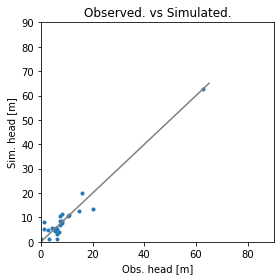

Error is - 2.838862154703158
Params are - [6.98322276e-01 1.44750651e+01 1.41495848e+01 4.94535717e-01
 1.06427905e+00 4.93747292e-01 2.37464283e-03 6.97162458e-01
 1.59296682e-01 3.14392264e-01 1.95413091e-03 3.50806218e+00]


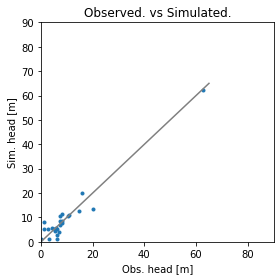

Error is - 2.8389932876712725
Params are - [6.98196778e-01 1.39583134e+01 1.39609875e+01 4.89772014e-01
 1.07380755e+00 4.90225146e-01 2.38889257e-03 6.88718224e-01
 1.57424927e-01 3.16134247e-01 2.00402981e-03 3.56638085e+00]


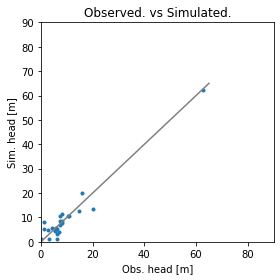

Error is - 2.839073705804406
Params are - [6.92729776e-01 1.44612142e+01 1.36961640e+01 4.89283721e-01
 1.06991952e+00 4.88108875e-01 2.38947310e-03 7.00739563e-01
 1.59540638e-01 3.16937017e-01 2.00103763e-03 3.52722637e+00]


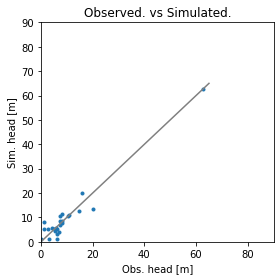

Error is - 2.8388279854594853
Params are - [6.97578141e-01 1.39808676e+01 1.37861531e+01 4.90997153e-01
 1.06719962e+00 4.98351823e-01 2.37836363e-03 7.05837547e-01
 1.58064055e-01 3.14898989e-01 1.98174182e-03 3.58079585e+00]


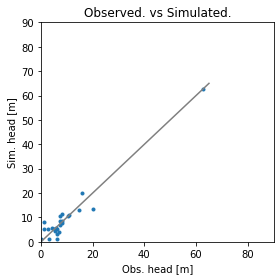

Error is - 2.83934434108673
Params are - [7.00081366e-01 1.37371860e+01 1.34290144e+01 4.91118038e-01
 1.06577162e+00 5.07060463e-01 2.37507792e-03 7.16957513e-01
 1.57043607e-01 3.15154432e-01 1.96737220e-03 3.60582875e+00]


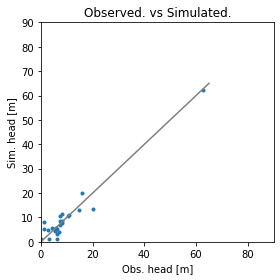

Error is - 2.8391947237838204
Params are - [6.90306270e-01 1.42815027e+01 1.38089113e+01 4.87806733e-01
 1.06533508e+00 4.86462078e-01 2.40022249e-03 6.97236547e-01
 1.57289853e-01 3.16963221e-01 2.01406389e-03 3.55400833e+00]


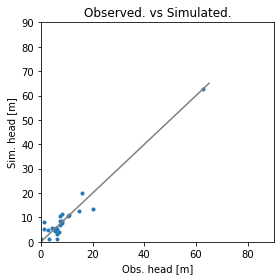

Error is - 2.838759083089806
Params are - [7.02823768e-01 1.44865081e+01 1.39304048e+01 4.90916705e-01
 1.06655059e+00 4.95959296e-01 2.37347543e-03 6.93979592e-01
 1.59962295e-01 3.16171421e-01 1.96700621e-03 3.52574662e+00]


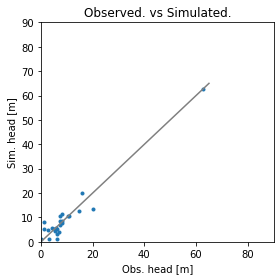

Error is - 2.838953205251997
Params are - [7.10498446e-01 1.47371200e+01 1.37989463e+01 4.91354036e-01
 1.06514611e+00 5.01713059e-01 2.36362274e-03 6.92279354e-01
 1.61077930e-01 3.17266812e-01 1.93847824e-03 3.49657445e+00]


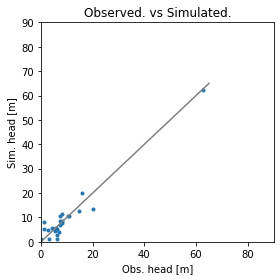

Error is - 2.838817870376144
Params are - [6.99508410e-01 1.43224593e+01 1.31334438e+01 4.82968832e-01
 1.07362619e+00 4.96240105e-01 2.37759519e-03 7.04392439e-01
 1.57673141e-01 3.18574960e-01 1.98780506e-03 3.57438136e+00]


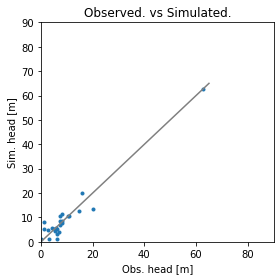

Error is - 2.8392328226675585
Params are - [7.03244741e-01 1.42452838e+01 1.40508262e+01 4.91335239e-01
 1.07256643e+00 4.97262706e-01 2.36043600e-03 6.96317529e-01
 1.60459081e-01 3.14113794e-01 1.96744839e-03 3.55783768e+00]


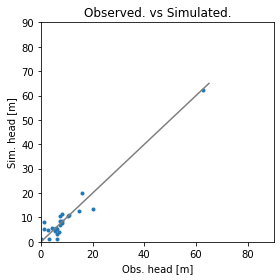

Error is - 2.8388109202644545
Params are - [6.93540888e-01 1.42724479e+01 1.38693900e+01 4.88688860e-01
 1.06714292e+00 4.89162235e-01 2.39027587e-03 6.97006793e-01
 1.58082160e-01 3.16250864e-01 2.00241002e-03 3.55496567e+00]


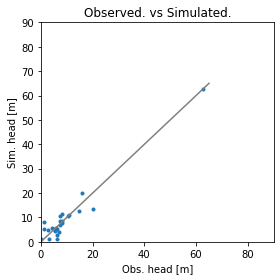

Error is - 2.838813626479343
Params are - [7.02615760e-01 1.44109192e+01 1.34706418e+01 4.86175174e-01
 1.06701518e+00 4.90157141e-01 2.37644530e-03 6.98799064e-01
 1.57031029e-01 3.17994794e-01 2.02858285e-03 3.51087286e+00]


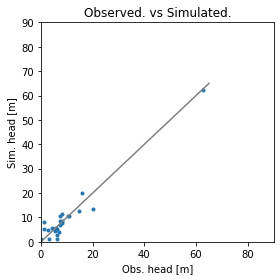

Error is - 2.8388362687012623
Params are - [7.02020997e-01 1.42964354e+01 1.32359474e+01 4.86758467e-01
 1.07595552e+00 4.96911434e-01 2.38439534e-03 7.01255736e-01
 1.57353603e-01 3.18591228e-01 1.97149868e-03 3.54121056e+00]


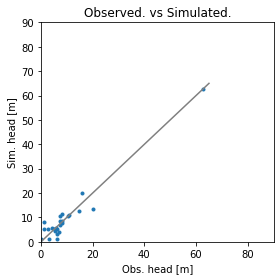

Error is - 2.839033262005965
Params are - [7.04272507e-01 1.40830777e+01 1.38584978e+01 4.88026642e-01
 1.06925378e+00 4.97021249e-01 2.37110749e-03 6.94104945e-01
 1.57040431e-01 3.15590698e-01 1.98426309e-03 3.57277926e+00]


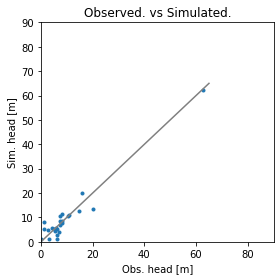

Error is - 2.8384794759016376
Params are - [7.03649222e-01 1.43617374e+01 1.36074807e+01 4.94442257e-01
 1.06800845e+00 5.02779631e-01 2.38398842e-03 7.02294895e-01
 1.57364647e-01 3.16332325e-01 1.92963342e-03 3.53901520e+00]


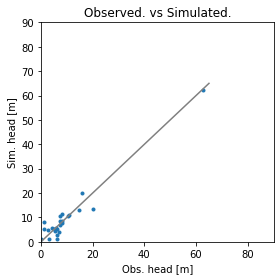

Error is - 2.8388710244389253
Params are - [7.08017341e-01 1.44584344e+01 1.34439650e+01 4.99860866e-01
 1.06656675e+00 5.11946289e-01 2.38807830e-03 7.07056440e-01
 1.56594188e-01 3.16443985e-01 1.87171679e-03 3.52718553e+00]


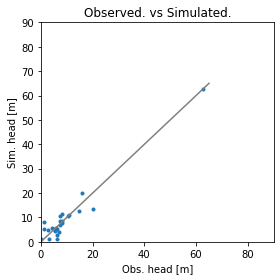

Error is - 2.8391882504584105
Params are - [7.05737506e-01 1.43703211e+01 1.30799257e+01 4.82911176e-01
 1.06859317e+00 4.97139174e-01 2.36868949e-03 7.03080620e-01
 1.56432172e-01 3.20447815e-01 2.01500614e-03 3.49817536e+00]


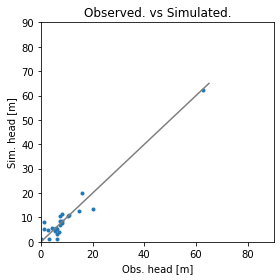

Error is - 2.8387814261547515
Params are - [6.97212671e-01 1.42340406e+01 1.40249689e+01 4.92005542e-01
 1.06963234e+00 4.93209821e-01 2.38474029e-03 6.95864229e-01
 1.58721567e-01 3.14571963e-01 1.97055839e-03 3.57026900e+00]


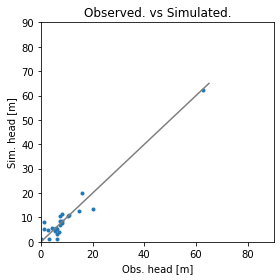

Error is - 2.838938304665389
Params are - [6.94659418e-01 1.45010177e+01 1.35891564e+01 4.90584681e-01
 1.06938123e+00 4.91382725e-01 2.38994469e-03 7.02727655e-01
 1.59156629e-01 3.17300673e-01 1.98420141e-03 3.51927794e+00]


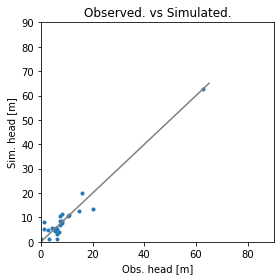

Error is - 2.8388536630244157
Params are - [7.00145587e-01 1.47162327e+01 1.34246948e+01 4.88974753e-01
 1.06408974e+00 4.98371757e-01 2.37233496e-03 7.10449282e-01
 1.59060751e-01 3.16951529e-01 1.96112996e-03 3.51782586e+00]


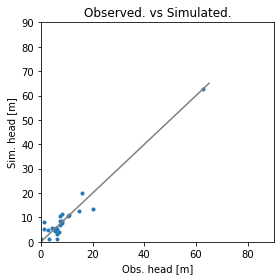

Error is - 2.8385631153877338
Params are - [7.00884685e-01 1.44490281e+01 1.34979806e+01 4.92975795e-01
 1.06545119e+00 5.00424892e-01 2.38350113e-03 7.04358323e-01
 1.57682993e-01 3.14917797e-01 1.96821745e-03 3.53300684e+00]


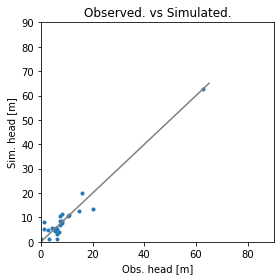

Error is - 2.8390699689873187
Params are - [7.05104478e-01 1.42349656e+01 1.37151861e+01 4.89018289e-01
 1.06666728e+00 5.00178313e-01 2.36943871e-03 6.98945928e-01
 1.57120309e-01 3.15214178e-01 1.97317832e-03 3.56244921e+00]


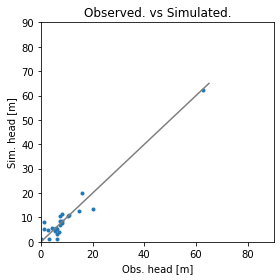

Error is - 2.8387214875589892
Params are - [6.97270683e-01 1.44345046e+01 1.36206638e+01 4.90193083e-01
 1.06870274e+00 4.93581622e-01 2.38481819e-03 7.01782224e-01
 1.58647549e-01 3.16779049e-01 1.98144563e-03 3.53007076e+00]


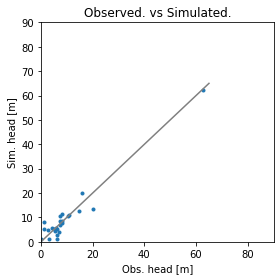

Error is - 2.8387333496595026
Params are - [7.01266355e-01 1.42541581e+01 1.30666043e+01 4.84343481e-01
 1.07250674e+00 4.97786135e-01 2.38643647e-03 7.05281086e-01
 1.56872067e-01 3.18520384e-01 2.00780126e-03 3.57733306e+00]


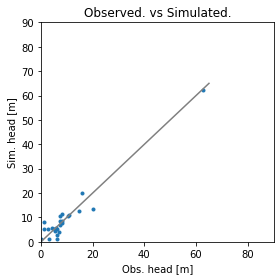

Error is - 2.838924295590048
Params are - [6.99629838e-01 1.39359780e+01 1.37318125e+01 4.89132565e-01
 1.07409889e+00 4.93064065e-01 2.39109458e-03 6.91132896e-01
 1.56743218e-01 3.16222596e-01 2.00858077e-03 3.57748725e+00]


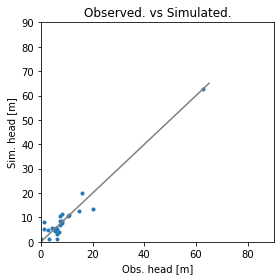

Error is - 2.8386952526487716
Params are - [7.00016650e-01 1.45211690e+01 1.35014742e+01 4.89014206e-01
 1.06659203e+00 4.97044834e-01 2.37702487e-03 7.05620186e-01
 1.58481368e-01 3.16769296e-01 1.97299266e-03 3.53274121e+00]


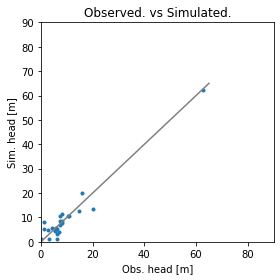

Error is - 2.8386888506151466
Params are - [6.99450398e-01 1.42605545e+01 1.34288277e+01 4.90068028e-01
 1.07072362e+00 4.97884027e-01 2.38696802e-03 7.04104209e-01
 1.58620708e-01 3.17954539e-01 1.94005202e-03 3.56085728e+00]


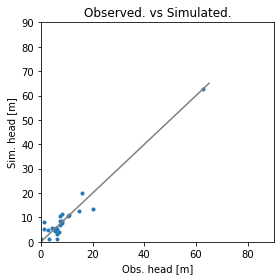

Error is - 2.8388196856287604
Params are - [6.97281942e-01 1.43682971e+01 1.39203915e+01 4.92039719e-01
 1.06123642e+00 4.95185493e-01 2.37954346e-03 7.01964362e-01
 1.58846994e-01 3.14698169e-01 1.98487578e-03 3.55713205e+00]


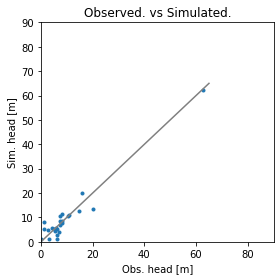

Error is - 2.8387081789509536
Params are - [7.01675431e-01 1.47484364e+01 1.33925590e+01 4.87974794e-01
 1.06899845e+00 4.93217382e-01 2.38577180e-03 6.96737020e-01
 1.58267031e-01 3.18356938e-01 1.97515497e-03 3.51360280e+00]


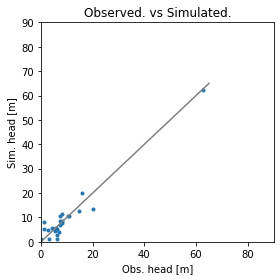

Error is - 2.8388758608848352
Params are - [7.02703878e-01 1.44243635e+01 1.31703484e+01 4.86254740e-01
 1.07625532e+00 4.96055694e-01 2.38563004e-03 6.99738981e-01
 1.57387432e-01 3.19167553e-01 1.97040088e-03 3.53001172e+00]


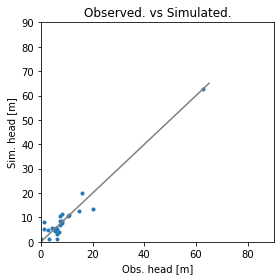

Error is - 2.8386200540380946
Params are - [6.98637426e-01 1.43823137e+01 1.37328807e+01 4.90593475e-01
 1.06499114e+00 4.95403043e-01 2.38106510e-03 7.01408017e-01
 1.58482104e-01 3.15815515e-01 1.98125706e-03 3.55035197e+00]


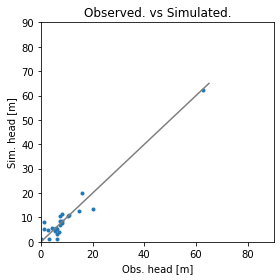

Error is - 2.838659364944059
Params are - [7.00332245e-01 1.44801770e+01 1.40572023e+01 4.96596402e-01
 1.06242638e+00 4.94861572e-01 2.38815662e-03 6.96813500e-01
 1.58696111e-01 3.14830854e-01 1.96638026e-03 3.50875752e+00]


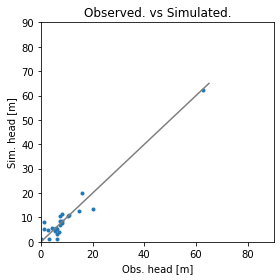

Error is - 2.8387630671642374
Params are - [6.96844310e-01 1.44032601e+01 1.38177643e+01 4.95126930e-01
 1.06827259e+00 5.01728608e-01 2.39125840e-03 7.02075948e-01
 1.59615738e-01 3.14883697e-01 1.91523538e-03 3.57191347e+00]


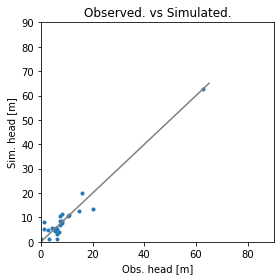

Error is - 2.8384905836449232
Params are - [7.06469753e-01 1.45635333e+01 1.34104119e+01 4.93686257e-01
 1.06833313e+00 5.04817909e-01 2.37759158e-03 7.04713079e-01
 1.58820203e-01 3.16399765e-01 1.92687910e-03 3.53064529e+00]


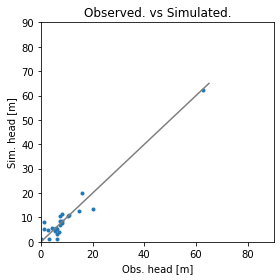

Error is - 2.8385052263579
Params are - [7.04340817e-01 1.46568561e+01 1.31524068e+01 4.90649694e-01
 1.06562716e+00 5.02705004e-01 2.38193572e-03 7.07330450e-01
 1.58197235e-01 3.18383301e-01 1.95145085e-03 3.50873800e+00]


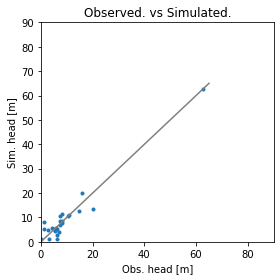

Error is - 2.838817760341768
Params are - [7.05958596e-01 1.45299027e+01 1.32487185e+01 4.86782099e-01
 1.06654602e+00 4.94348950e-01 2.37386383e-03 7.01994482e-01
 1.57066648e-01 3.18654834e-01 2.01280977e-03 3.49656429e+00]


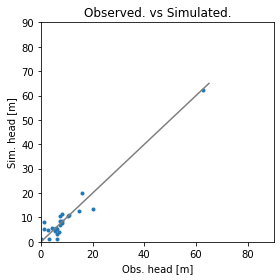

Error is - 2.838599583102075
Params are - [6.99122881e-01 1.44349207e+01 1.36755029e+01 4.93040723e-01
 1.06784094e+00 4.99883693e-01 2.38690976e-03 7.02055582e-01
 1.58978465e-01 3.15826481e-01 1.93962898e-03 3.55307617e+00]


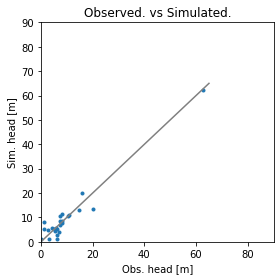

Error is - 2.8386399267537725
Params are - [6.99362323e-01 1.44380567e+01 1.30935944e+01 4.91346328e-01
 1.06848307e+00 5.00772328e-01 2.39388585e-03 7.11436837e-01
 1.56556118e-01 3.17309620e-01 1.95647607e-03 3.54728606e+00]


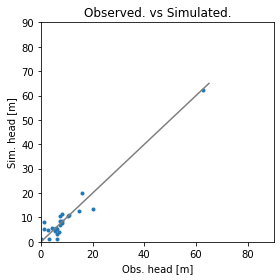

Error is - 2.838582830356813
Params are - [7.00602397e-01 1.47010566e+01 1.39618933e+01 4.99086693e-01
 1.06185631e+00 4.99443188e-01 2.38216638e-03 7.01161301e-01
 1.59593688e-01 3.14758862e-01 1.90712682e-03 3.49069179e+00]


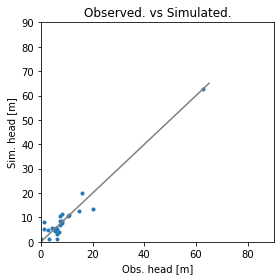

Error is - 2.8383515478311963
Params are - [7.05153355e-01 1.45651353e+01 1.34647053e+01 4.94719359e-01
 1.06451924e+00 5.04624629e-01 2.38334268e-03 7.04556676e-01
 1.57975896e-01 3.16163500e-01 1.92109598e-03 3.53139093e+00]


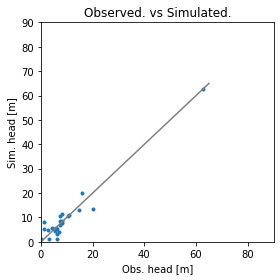

Error is - 2.8387270055262404
Params are - [7.09094691e-01 1.46304506e+01 1.33867260e+01 4.96982497e-01
 1.06242749e+00 5.10146133e-01 2.38260493e-03 7.05943902e-01
 1.57640070e-01 3.15855725e-01 1.89092115e-03 3.53205102e+00]


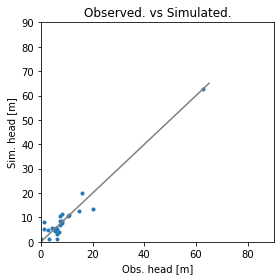

Error is - 2.838617800712129
Params are - [7.01328261e-01 1.42206533e+01 1.37048345e+01 4.98061742e-01
 1.06347700e+00 5.06890076e-01 2.38198422e-03 7.10905155e-01
 1.58307892e-01 3.14220038e-01 1.91837680e-03 3.55082357e+00]


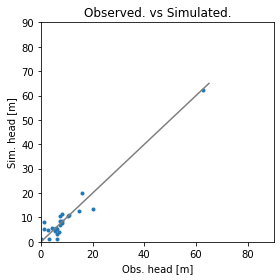

Error is - 2.8383788046338494
Params are - [7.03205644e-01 1.43978348e+01 1.36298127e+01 4.98530252e-01
 1.06536425e+00 5.04703498e-01 2.39155771e-03 7.02902818e-01
 1.58064643e-01 3.15382804e-01 1.91143648e-03 3.53469890e+00]


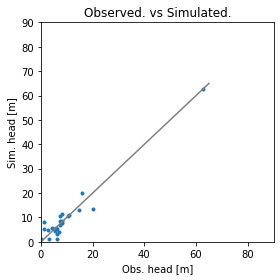

Error is - 2.8391176584482896
Params are - [7.04397771e-01 1.46813293e+01 1.37359566e+01 4.98886801e-01
 1.06033942e+00 5.05000883e-01 2.38237951e-03 7.04218563e-01
 1.57832625e-01 3.13768938e-01 1.93960786e-03 3.50222310e+00]


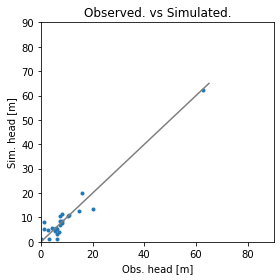

Error is - 2.8385283015303804
Params are - [7.00687241e-01 1.43657482e+01 1.35056099e+01 4.92272721e-01
 1.06812757e+00 4.99663241e-01 2.38582089e-03 7.04132797e-01
 1.58423687e-01 3.16908139e-01 1.93994098e-03 3.54619873e+00]


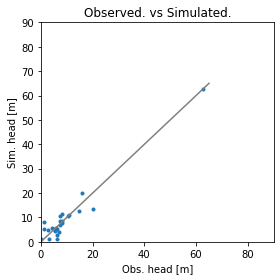

Error is - 2.8385302511296695
Params are - [7.03575089e-01 1.44426354e+01 1.30156499e+01 4.91637814e-01
 1.06958686e+00 5.08823617e-01 2.38080162e-03 7.12729155e-01
 1.57711817e-01 3.17238837e-01 1.90887307e-03 3.56056306e+00]


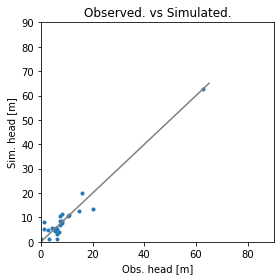

Error is - 2.8386170186629394
Params are - [7.05247139e-01 1.44855188e+01 1.39662672e+01 4.96936469e-01
 1.06371413e+00 5.04254742e-01 2.37289168e-03 6.98321205e-01
 1.60044427e-01 3.14748274e-01 1.91084343e-03 3.52424735e+00]


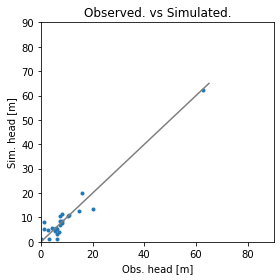

Error is - 2.8385290165032395
Params are - [7.07073655e-01 1.45584626e+01 1.33658785e+01 4.98746488e-01
 1.06699323e+00 5.11099310e-01 2.38435020e-03 7.07835556e-01
 1.58378829e-01 3.16064506e-01 1.87432684e-03 3.51683067e+00]


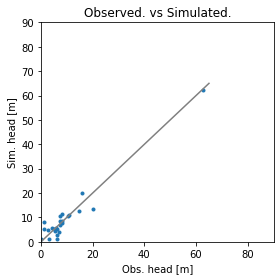

Error is - 2.8385752474856547
Params are - [7.05340385e-01 1.47764246e+01 1.33374321e+01 4.91392345e-01
 1.06909341e+00 5.00313816e-01 2.38382541e-03 6.97826817e-01
 1.58564863e-01 3.17967394e-01 1.92986543e-03 3.51069358e+00]


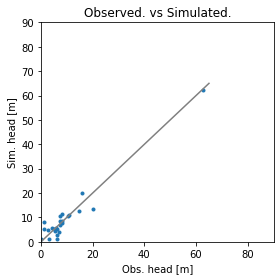

Error is - 2.8386116507024854
Params are - [7.01437049e-01 1.45600434e+01 1.29711936e+01 4.91593597e-01
 1.06975282e+00 5.02292330e-01 2.39474023e-03 7.10328370e-01
 1.56581734e-01 3.17975678e-01 1.94056914e-03 3.53501085e+00]


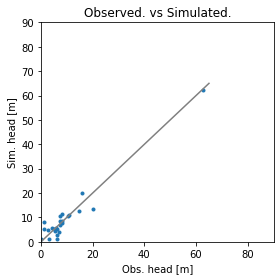

Error is - 2.8384701705646544
Params are - [7.02389571e-01 1.45414123e+01 1.32199620e+01 4.92929315e-01
 1.06824315e+00 5.02782933e-01 2.38927810e-03 7.07326579e-01
 1.57447407e-01 3.17168827e-01 1.93313771e-03 3.53231997e+00]


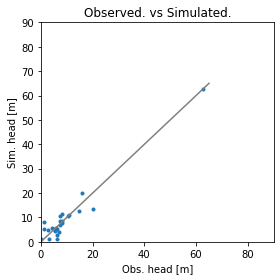

Error is - 2.8384303646369307
Params are - [7.08105754e-01 1.46283901e+01 1.31860344e+01 4.95470776e-01
 1.06569305e+00 5.07146585e-01 2.38111688e-03 7.07472493e-01
 1.57392520e-01 3.17121195e-01 1.91070171e-03 3.50272266e+00]


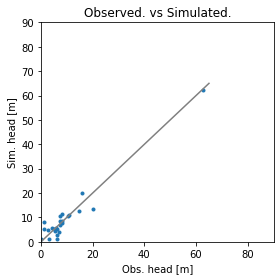

Error is - 2.838540993288897
Params are - [7.07876798e-01 1.43501431e+01 1.27703342e+01 4.88822153e-01
 1.07231714e+00 5.08870989e-01 2.38568534e-03 7.09418639e-01
 1.56410435e-01 3.18582536e-01 1.94379968e-03 3.56711218e+00]


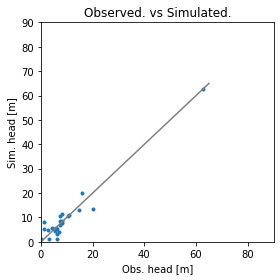

Error is - 2.8386825787458014
Params are - [7.03561546e-01 1.42037282e+01 1.33002791e+01 4.96088135e-01
 1.06561732e+00 5.09426557e-01 2.38433630e-03 7.14685093e-01
 1.57080189e-01 3.15476528e-01 1.92338345e-03 3.55651349e+00]


KeyboardInterrupt: 

In [39]:
# run optimization 

"""             {-12:Alluvium_Aua, 
               -14:Alluvium_Fagaalu, 
               -15:Alluvium_minor,
               -13:Alluvium_Utulei,
               -11:Alluvium_Vaipito,
               -10:Alluvium_Vatia,
               -50:Dikes,
               -30:Pago_inner_E,
               -40:Pago_inner_W,
               -20:Pago_outer,
               -60:Trachyte,     
               -16:Alluvium_Laulii}}   """

# Start
# params = [4.6, 13.0, 0.1, 5.0, 2.6, 0.4, 0.3, 0.1, 0.5, 0.6, 0.3]
# Better
# params = [2.1, 28.6, 0.05, 7.2, 1.8, 0.7, 0.01, 0.15, 0.4, 1.5, 0.01]
# Better
# params = [2.6, 39, 1, 14, 3.7, 1.2, 0.001, 0.37, 0.9, 0.7, 0.003, 1]

params = [0.7, 16, 16,  0.5, 1.0, 0.5, 0.002, 0.75, 0.17, 0.3, 0.0018, 3.75] 

# The main optimization function
results = opt.minimize(calibrateo, x0= params, method="Nelder-Mead",tol = 0.1)

In [ ]:
bestso far [2.14, 35, 2.41, 1.18, 1.38, 1.16, 0.01 0.3, 0.2, 0.3 0.2, 2.0]

[6.85496496e-01 3.25213077e+01 6.80654543e+00 1.86383679e+00
 1.51808179e+00 5.06743373e+00 1.03195373e-03 9.94528435e-01
 2.66379794e-01 2.22365422e-01 1.67176201e-03 2.62836815e+00]

[0.7, 32, 6.8, 1.9, 1.5, 5.0, 0.001, 1.0, 0.25, 0.2, 0.0015, 2.5] 
[0.4, 55, 9.1, 1.3, 1.4, 1.4, 0.001, 1.0, 0.21, 0.3, 0.0017, 2.6] 
[0.7, 16, 16,  0.5, 1.0, 0.5, 0.0023, 0.7, 0.17, 0.3, 0.0017, 3.75] 



Error is - 2.8476282593513105
Params are - [7.00310409e-01 1.56746557e+01 1.61862395e+01 5.17194242e-01
 1.06523176e+00 4.89575411e-01 2.30077223e-03 6.91173771e-01
 1.75302810e-01 3.08299591e-01 1.74498256e-03 3.48371787e+00]



In [26]:
calibrateo(results["x"])

Error is - 3.2446989745873096
Params are - [2.66734909e+00 3.88938662e+01 1.35015054e-03 1.44380768e+01
 3.70378031e+00 1.11188899e+00 9.53875900e-04 3.65098285e-01
 8.97305579e-01 7.23140076e-01 3.12300993e-03]


3.2446989745873096

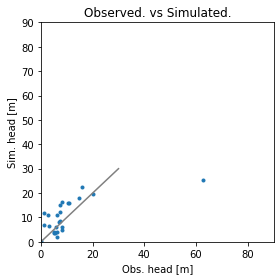

In [30]:
plot_calibrateo(Howd_we_do)